# Machine Learning Based Fraud Detection – Improving existing approaches using Generative Adversarial Networks 

---

**Part 2 - Model training and evaluation** <br>
Master Thesis by Lukas Menzel



## 1. Importing and dataset preprocessing

### 1.1 Importing all necessary libraries

In [29]:
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
import seaborn as sns
import shap
import math
from ctgan import CTGANSynthesizer
from xgboost import XGBClassifier
from sklearn.svm import SVC
import sklearn
from sklearn import metrics
from sklearn.metrics import ndcg_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from scipy import stats
from sdv.evaluation import evaluate
from sdv.metrics.tabular import BNLikelihood, BNLogLikelihood, GMLogLikelihood
import warnings
import os

### 1.2 Data loading

In [5]:
df = pd.read_csv("uscecchini28.csv") # Make sure to insert the correct filepath
df.head() #Shows the files structure

fyear  gvkey    sich  insbnk  understatement  option  p_aaer  new_p_aaer  \
0   1990   1009  3460.0       0               0       0     NaN         NaN   
1   1990   1011  4841.0       0               0       0     NaN         NaN   
2   1990   1017  3812.0       0               0       0     NaN         NaN   
3   1990   1021  3861.0       0               0       0     NaN         NaN   
4   1990   1028  7385.0       0               0       0     NaN         NaN   

   misstate     act  ...  soft_assets     ch_cs     ch_cm    ch_roa  issue  \
0         0  10.047  ...     0.312448  0.095082  0.082631 -0.019761      1   
1         0   1.247  ...     0.315904  0.188832 -0.211389 -0.117832      1   
2         0  55.040  ...     0.605342  0.097551 -0.105780  0.091206      1   
3         0  24.684  ...     0.793068 -0.005725 -0.249704  0.017545      1   
4         0  17.325  ...     0.869182 -0.231536 -1.674893 -0.466667      0   

         bm       dpi      reoa      EBIT    ch_fcf  
0  0.413170  0.873555  0.167620  0.161961 -0.042140  
1  0.157887  0.745139 -0.428957 -0.157888  0.100228  
2  2.231337  1.015131  0.394768  0.063681  0.066348  
3  1.043582  1.026261  0.094822  0.088347 -0.017358  
4 -1.602508  0.598443 -0.942379 -0.700821  0.130349  

[5 rows x 51 columns]

In [6]:
#Adding a mapping to more easily interpret the values, instead of the identifiers

mapping = {'che':'Cash and short-term investments', 'rect':'Receivables, total', 'invt':'Inventories, total', 
           'ivst':'Short-term investements, total', 'act':'Current assets, total', 'ppegt':'Property, plant and equipment, total',
           'ivao':'Investments and advances, total', 'at':'Assets, total', 'ap':'accounts payable, trade', 'dlc':'Debt in current liabilities, total',
           'txp':'Income taxes payable', 'dltt':'Long-term debt, total', 'lct':'Current liabilities, total', 'lt':'Liabilities, total',
           'ceq':'Common/ordinary equity', 'pstk':'Preferred/preference stock (capital), total', 're':'Retained earnings',
           
           'sale':'Sales/turnover, net', 'cogs':'Cost of goods sold', 'dp':'Depreciation and amortization', 'xint':'Interest and related expense, total',
           'txt':'Income taxes, total', 'ib':'Income before extraordinary items', 'ni':'Net income (loss)', 
           
           'dltis':'Long term debt issuance', 'sstk':'Sales of common preferred stock', 
           
           'prcc_f':'Price close, annual, fiscal', 'csho':'Common shares outstanding',
           
           'dch_wc':'Working capital accruals', 'ch_rsst':'RSST accrual', 'dch_rec':'Change in receivables', 'dch_inv':'Change in inventory', 
           'soft_assets':'% of soft assets', 'dpi':'Depreciation index', 
           
           'ch_cs':'Change in cash sales', 'ch_cm':'Change in cash margin', 'ch_roa':'Change in return on assets',
           'ch_fcf':'Change in free cash flow', 'EBIT':'EBIT over total assets', 'reoa':'Retained earnings over total assets',
           
           'issue':'Actual issuance', 'bm':'Book-to-market ratio'
          }
df = df.rename(columns=mapping)
predictors = ['Cash and short-term investments', 'Receivables, total', 'Inventories, total', 'Short-term investements, total', 'Current assets, total', 
            'Property, plant and equipment, total', 'Investments and advances, total', 'Assets, total', 'accounts payable, trade', 'Debt in current liabilities, total',
            'Income taxes payable', 'Long-term debt, total', 'Current liabilities, total', 'Liabilities, total',
            'Common/ordinary equity', 'Preferred/preference stock (capital), total', 'Retained earnings',
            'Sales/turnover, net', 'Cost of goods sold', 'Depreciation and amortization', 'Interest and related expense, total',
            'Income taxes, total', 'Income before extraordinary items', 'Net income (loss)', 'Long term debt issuance', 'Sales of common preferred stock', 
            'Price close, annual, fiscal', 'Common shares outstanding',
           'Working capital accruals', 'RSST accrual', 'Change in receivables', 'Change in inventory', 
           '% of soft assets', 'Depreciation index', 
           'Change in cash sales', 'Change in cash margin', 'Change in return on assets',
           'Change in free cash flow', 'EBIT over total assets', 'Retained earnings over total assets', 'Actual issuance', 'Book-to-market ratio']

predictors_raw = ['Cash and short-term investments', 'Receivables, total', 'Inventories, total', 'Short-term investements, total', 'Current assets, total', 
            'Property, plant and equipment, total', 'Investments and advances, total', 'Assets, total', 'accounts payable, trade', 'Debt in current liabilities, total',
            'Income taxes payable', 'Long-term debt, total', 'Current liabilities, total', 'Liabilities, total',
            'Common/ordinary equity', 'Preferred/preference stock (capital), total', 'Retained earnings',
            'Sales/turnover, net', 'Cost of goods sold', 'Depreciation and amortization', 'Interest and related expense, total',
            'Income taxes, total', 'Income before extraordinary items', 'Net income (loss)', 'Long term debt issuance', 'Sales of common preferred stock', 
            'Price close, annual, fiscal', 'Common shares outstanding']

predictors_ratio = ['Working capital accruals', 'RSST accrual', 'Change in receivables', 'Change in inventory', 
           '% of soft assets', 'Depreciation index', 
           'Change in cash sales', 'Change in cash margin', 'Change in return on assets',
           'Change in free cash flow', 'EBIT over total assets', 'Retained earnings over total assets','Actual issuance', 'Book-to-market ratio']

df.head()

fyear  gvkey    sich  insbnk  understatement  option  p_aaer  new_p_aaer  \
0   1990   1009  3460.0       0               0       0     NaN         NaN   
1   1990   1011  4841.0       0               0       0     NaN         NaN   
2   1990   1017  3812.0       0               0       0     NaN         NaN   
3   1990   1021  3861.0       0               0       0     NaN         NaN   
4   1990   1028  7385.0       0               0       0     NaN         NaN   

   misstate  Current assets, total  ...  % of soft assets  \
0         0                 10.047  ...          0.312448   
1         0                  1.247  ...          0.315904   
2         0                 55.040  ...          0.605342   
3         0                 24.684  ...          0.793068   
4         0                 17.325  ...          0.869182   

   Change in cash sales  Change in cash margin  Change in return on assets  \
0              0.095082               0.082631                   -0.019761   
1              0.188832              -0.211389                   -0.117832   
2              0.097551              -0.105780                    0.091206   
3             -0.005725              -0.249704                    0.017545   
4             -0.231536              -1.674893                   -0.466667   

   Actual issuance  Book-to-market ratio  Depreciation index  \
0                1              0.413170            0.873555   
1                1              0.157887            0.745139   
2                1              2.231337            1.015131   
3                1              1.043582            1.026261   
4                0             -1.602508            0.598443   

   Retained earnings over total assets  EBIT over total assets  \
0                             0.167620                0.161961   
1                            -0.428957               -0.157888   
2                             0.394768                0.063681   
3                             0.094822                0.088347   
4                            -0.942379               -0.700821   

   Change in free cash flow  
0                 -0.042140  
1                  0.100228  
2                  0.066348  
3                 -0.017358  
4                  0.130349  

[5 rows x 51 columns]

### 1.3 Training and test split

In [8]:
#The default train/test split of scikit-learn is not appicable here, as we have a bias if we have consecutive fraud years.

#test period = 2003 - 2008
#train period = 1991 - 2001

y = df['misstate']
X = df[predictors]
X_raw = df[predictors_raw]


y_train = df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001), ['misstate']]
y_train = np.ravel(y_train)
#y_train.to_csv('ytrain.csv') #To check for correctness
#y_train.to_numpy()

y_test = df.loc[(df['fyear']>= 2003) & (df['fyear']<= 2008), ['misstate']]
y_test= np.ravel(y_test)
#y_test.to_csv('ytest.csv')
#y_test.to_numpy()

X_train = df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001)]
X_train = X_train.iloc[:, 9:]
#X_train.to_csv('Xtrain.csv')
#X_train.head()

X_test = df.loc[(df['fyear']>= 2003) & (df['fyear']<= 2008)]
X_test = X_test.iloc[:, 9:]
#X_test.to_csv('Xtest.csv')

#Specifying X_train/test, but this time with only the 28 raw data variables instead of the full 42 variable set
X_train_raw = df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001)]
X_train_raw = X_train_raw[predictors_raw]
X_train_raw.to_csv('Xtrain_raw.csv') #optional

X_test_raw = df.loc[(df['fyear']>= 2003) & (df['fyear']<= 2008)]
X_test_raw = X_test_raw[predictors_raw]
X_test_raw.to_csv('Xtest_raw.csv') #optional

#Specifying X_train/test, but this time with only the 14 ratio variables instead of the full 42 variable set
X_test_ratio = df.loc[(df['fyear']>= 2003) & (df['fyear']<= 2008)]
X_test_ratio = X_test_ratio[predictors_ratio]
#X_test_ratio.to_csv('Xtest_raw.csv') #optional

X_train_ratio = df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001)]
X_train_ratio = X_train_ratio[predictors_ratio]


print('X_train shape:', X_train.shape)
print('X_Test shape:', X_test.shape)
print('Y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape, '\n')
print('X_train raw shape: ', X_train_raw.shape)
print('X_test raw shape', X_test_raw.shape)
print('X_train ratio shape:', X_train_ratio.shape)
print('X_test ratio shape', X_test_ratio.shape)

X_train shape: (67166, 42)
X_Test shape: (35166, 42)
Y_train shape: (67166,)
y_test shape: (35166,) 

X_train raw shape:  (67166, 28)
X_test raw shape (35166, 28)
X_train ratio shape: (67166, 14)
X_test ratio shape (35166, 14)


## 2.0 Training the baseline model


### 2.1 XGBoost

In [9]:
# XGB with 42 variables

# Hyperparameter found during gridsearch in part 3.0, while scale/pos weight is calculated by dividing the positive instance (1=fraud) by the negative instances according 
# to the XGB guidelines
model = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(146045/975))
model.fit(X_train, y_train)

# XGB trained only on the 28 raw data variables

model_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(146045/975))
model_raw.fit(X_train_raw, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:30:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:30:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.238862021844334,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
model_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(146045/975))
eval_set = [(X_test_raw, y_test)]
model_raw.fit(X_train_raw, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.64512
[1]	validation_0-auc:0.66718
[2]	validation_0-auc:0.67280
[3]	validation_0-auc:0.68460
[4]	validation_0-auc:0.69317
[5]	validation_0-auc:0.69464
[6]	validation_0-auc:0.69190
[7]	validation_0-auc:0.69633
[8]	validation_0-auc:0.69808
[9]	validation_0-auc:0.70746
[10]	validation_0-auc:0.70689
[11]	validation_0-auc:0.71399
[12]	validation_0-auc:0.71964
[13]	validation_0-auc:0.72312
[14]	validation_0-auc:0.72427
[15]	validation_0-auc:0.72526
[16]	validation_0-auc:0.72529
[17]	validation_0-auc:0.72398
[18]	validation_0-auc:0.72318
[19]	validation_0-auc:0.72151
[20]	validation_0-auc:0.71919
[21]	validation_0-auc:0.72216
[22]	validation_0-auc:0.72061
[23]	validation_0-auc:0.72122
[24]	validation_0-auc:0.72208
[25]	validation_0-auc:0.72040
[26]	validation_0-auc:0.72165
[27]	validation_0-auc:0.72600
[28]	validation_0-auc:0.72397
[29]	validation_0-auc:0.72399
[30]	validation_0-auc:0.72183
[31]	validation_0-auc:0.72219
[32]	validation_0-auc:0.72409
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.238862021844334,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

### 2.2 Logit Model

In [11]:
##Imputing missing values with the mean of the  column for Logit and SVM model

#Fill empty/NA values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


X_train_imputed = imputer.fit_transform(X_train)
X_train_raw_imputed = imputer.fit_transform(X_train_raw)
X_train_ratio_imputed = imputer.fit_transform(X_train_ratio)

X_test_imputed = imputer.fit_transform(X_test)
X_test_raw_imputed = imputer.fit_transform(X_test_raw)
X_test_ratio_imputed = imputer.fit_transform(X_test_ratio)

print('X_train shape:', X_train.shape)
print('X_Test shape:', X_test.shape)
print('X_train_imputed shape:', X_train_imputed.shape)
print('X_Test_imputed shape:', X_test_imputed.shape)

X_train shape: (67166, 42)
X_Test shape: (35166, 42)
X_train_imputed shape: (67166, 42)
X_Test_imputed shape: (35166, 42)


In [12]:
#train logit model on full 42 variables
model_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model_logit.fit(X_train_imputed, y_train)

#on 28 raw variables
model_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model_logit_raw.fit(X_train_raw_imputed, y_train)
                                
#on 14 financial ratios
model_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model_logit_ratio.fit(X_train_ratio_imputed, y_train)                            
                                

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=10000))])

### 2.3 SVM Model

In [163]:
model_svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
model_svm.fit(X_train_raw_imputed, y_train) #raw variables
#model_svm_ratio = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
#model_svm_ratio.fit(X_train_ratio_imputed, y_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

Making predictions

In [11]:
#XGB on 42 and 28 variables
y_pred = model.predict(X_test)
y_pred_raw = model_raw.predict(X_test_raw)

#Logit on 42, 28 and 14 variables
y_pred_logit = model_logit.predict(X_test_imputed) #42
y_pred_logit_raw = model_logit_raw.predict(X_test_raw_imputed) #28
y_pred_logit_ratio = model_logit_ratio.predict(X_test_ratio_imputed) #14

#SVM on 28 and 14
y_pred_svm = model_svm.predict(X_test_raw) #28
y_pred_svm_ratio = model_svm_ratio.predict(X_test_ratio) #14

print(y_pred_svm.shape)
#y_pred.tofile('y_pred.csv',sep=',',format='%10.5f')

(35166,)


## 3.0 Synthetizing fraud cases with CTGAN

### 3.1 Data preprocessing

In [27]:
#Imputing missing values before training the GAN on it
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#warnings.filterwarnings("ignore", message="Numerical issues were encountered ") # disable some unnecessary warnings due to CTGAN Beta status

X_train_fraud= df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001) & (df['misstate']== 1)]
X_train_fraud_imputed = imputer.fit_transform(X_train_fraud)
X_train_fraud_imputed = pd.DataFrame(data=X_train_fraud_imputed, columns = X_train_fraud.columns)
X_train_fraud_imputed.astype({'Actual issuance': 'int64'}).dtypes
X_train_fraud_imputed = X_train_fraud_imputed.iloc[:, 9:]
X_train_fraud_raw_imputed = X_train_fraud_imputed[predictors_raw] #constructing dataset with raw variables
X_train_fraud_ratio_imputed = X_train_fraud_imputed[predictors_ratio] # with ratio vars

print(X_train_fraud_imputed.shape) #Checking the shapes
print(X_train_fraud_raw_imputed.shape)
print(X_train_fraud_ratio_imputed.shape)

(499, 42)
(499, 28)
(499, 14)


### 3.2 GAN training and making predictions

In [43]:
#Training the GAN on 42, 28 or 14 variables versions of the dataset
import warnings
warnings.filterwarnings('ignore')

data42 = X_train_fraud_imputed
data28 = X_train_fraud_raw_imputed
data14 = X_train_fraud_ratio_imputed
discrete_columns = ['Actual issuance'] #all other columns are continuous values

#Training the model 
ctgan42 = CTGANSynthesizer(epochs=800, batch_size = 20)
ctgan42.fit(data42, discrete_columns)
ctgan42.save('ctgan42.pkl')

ctgan28 = CTGANSynthesizer(epochs=800, batch_size = 20)
ctgan28.fit(data28)
ctgan28.save('ctgan28.pkl')

ctgan14= CTGANSynthesizer(epochs=800, batch_size = 20)
ctgan14.fit(data14, discrete_columns)
ctgan14.save('ctgan14.pkl')

In [55]:
X_train_fraud_full= df.loc[(df['misstate']== 1)]
X_train_fraud_imputed_full = imputer.fit_transform(X_train_fraud_full)
X_train_fraud_imputed_full = pd.DataFrame(data=X_train_fraud_imputed_full, columns = X_train_fraud_full.columns)
X_train_fraud_imputed_full.astype({'Actual issuance': 'int64'}).dtypes

ctgan28test = CTGANSynthesizer(epochs=800, batch_size = 20)
ctgan28test.fit(X_train_fraud_imputed_full)

In [203]:
#training the copulaGAN model

from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN

field_distributions = {'Cash and short-term investments':'gamma',
                       'Receivables, total':'gamma', 
                       'Inventories, total':'gamma', 
                       'Short-term investements, total':'gamma', 
                       'Current assets, total':'gamma', 
                       'Property, plant and equipment, total':'gamma', 
                       'Investments and advances, total':'gamma',
                       'Assets, total':'gamma',
                       'accounts payable, trade':'gamma',
                       'Debt in current liabilities, total':'gamma',
                       'Income taxes payable':'gamma', 
                       'Long-term debt, total':'gamma', 
                       'Current liabilities, total':'gamma', 
                       'Liabilities, total':'gamma',
                       'Common/ordinary equity':'gamma', 
                       'Preferred/preference stock (capital), total':'gamma',
                       'Retained earnings':'gamma',
                       'Sales/turnover, net':'gamma',
                       'Cost of goods sold':'gamma', 
                       'Depreciation and amortization':'gamma',
                       'Interest and related expense, total':'gamma',
                       'Income taxes, total':'gamma', 
                       'Income before extraordinary items':'gamma', 
                       'Net income (loss)':'gamma', 
                       'Long term debt issuance':'gamma',
                       'Sales of common preferred stock':'gamma', 
                       'Price close, annual, fiscal':'gamma', 
                       'Common shares outstanding':'gamma',
                       'Working capital accruals':'gamma', 
                       'RSST accrual':'gamma', 
                       'Change in receivables':'gamma', 
                       'Change in inventory':'gamma',
                       '% of soft assets':'gamma', 
                       'Depreciation index':'gamma', 
                       #'Change in cash sales':'gamma', 
                       #'Change in cash margin',
                       #'Change in return on assets',
                       #'Change in free cash flow', 
                       #'EBIT over total assets',
                       #'Retained earnings over total assets',
                       'Actual issuance':'gamma', 
                       #'Book-to-market ratio'
}

#Training the models
cogan42 = CopulaGAN(epochs=800, batch_size = 20, field_distributions=field_distributions)
cogan42.fit(data42)
cogan42.save('cogan42.pkl')

cogan28 = CopulaGAN(epochs=800, batch_size = 20, field_distributions=field_distributions)
cogan28.fit(data28)
cogan28.save('cogan28.pkl')

cogan14= CopulaGAN(epochs=800, batch_size = 20, field_distributions=field_distributions)
cogan14.fit(data14)
cogan28.save('cogan14.pkl')

samples5p_co = cogan42.sample(2824)
samples5p_raw_co = cogan28.sample(2824)
samples5p_ratio_co = cogan14.sample(2824)

'Full 42 variables, 2824 fraud cases'

0.3340779508087558

In [249]:
display('CopulaGAN: 42 variables, 2824 fraud cases', evaluate(samples5p_co, X_train_fraud_imputed, aggregate=True))
display('CopulaGAN: 28 variables, 2824 fraud cases', evaluate(samples5p_raw_co, X_train_fraud_raw_imputed, aggregate=True))
display('CpoulaGAN: 14 variables, 2824 fraud cases', evaluate(samples5p_ratio_co, X_train_fraud_ratio_imputed, aggregate=True))


'CopulaGAN: 42 variables, 2824 fraud cases'

0.3440587890913641

'CopulaGAN: 28 variables, 2824 fraud cases'

0.5918604906733548

'CpoulaGAN: 14 variables, 2824 fraud cases'

0.3885233148050912

In [44]:
#CTGAN- Only run this cell or the one below depending which CTGAN variation you want to generate samples from
#create enough samples for injecting in the real distribution
#For the full 42 variables
samples1p = ctgan42.sample(168)
samples2p = ctgan42.sample(835)
samples5p = ctgan42.sample(2824)
samples10p = ctgan42.sample(6168)
samples20p = ctgan42.sample(12835)

#The 28 raw variables
samples1p_raw = ctgan28.sample(168)
samples2p_raw = ctgan28.sample(835)
samples5p_raw = ctgan28.sample(2824)
samples10p_raw = ctgan28.sample(6168)
samples20p_raw = ctgan28.sample(12835)

#14 Ratios
samples1p_ratio = ctgan14.sample(168)
samples2p_ratio = ctgan14.sample(835)
samples5p_ratio = ctgan14.sample(2824)
samples10p_ratio = ctgan14.sample(6168)
samples20p_ratio = ctgan14.sample(12835)

In [231]:
#CopulaGAN 
#create enough samples for injecting in the real distribution 
#For the full 42 variables
samples1p = cogan42.sample(168)
samples1p.replace([np.inf, -np.inf], np.nan, inplace=True)
samples2p = cogan42.sample(835)
samples2p.replace([np.inf, -np.inf], np.nan, inplace=True)
samples5p = cogan42.sample(2824)
samples5p.replace([np.inf, -np.inf], np.nan, inplace=True)
samples10p = cogan42.sample(6168)
samples10p.replace([np.inf, -np.inf], np.nan, inplace=True)
samples20p = cogan42.sample(12835)
samples20p.replace([np.inf, -np.inf], np.nan, inplace=True)

#The 28 raw variables
samples1p_raw = cogan28.sample(168)
samples1p_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
samples2p_raw = cogan28.sample(835)
samples2p_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
samples5p_raw = cogan28.sample(2824)
samples5p_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
samples10p_raw = cogan28.sample(6168)
samples10p_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
samples20p_raw = cogan28.sample(12835)
samples20p_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

#14 Ratios
samples1p_ratio = cogan14.sample(168)
samples1p_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
samples2p_ratio = cogan14.sample(835)
samples2p_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
samples5p_ratio = cogan14.sample(2824)
samples5p_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
samples10p_ratio = cogan14.sample(6168)
samples10p_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
samples20p_ratio = cogan14.sample(12835)
samples20p_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)

In [45]:
#Appending the fraud cases to the real training data

#Full 42
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train_1p = X_train.append(samples1p)
X_train_2p = X_train.append(samples2p)
X_train_5p = X_train.append(samples5p)
X_train_10p = X_train.append(samples10p)
X_train_20p = X_train.append(samples20p)

#Imputed ones for logit and SVM
X_train_1p_imputed = imputer.fit_transform(X_train_1p)
X_train_2p_imputed = imputer.fit_transform(X_train_2p)
X_train_5p_imputed = imputer.fit_transform(X_train_5p)
X_train_10p_imputed = imputer.fit_transform(X_train_10p)
X_train_20p_imputed = imputer.fit_transform(X_train_20p)

#Raw 28 variables
X_train_1p_raw = X_train_raw.append(samples1p_raw)
X_train_2p_raw = X_train_raw.append(samples2p_raw)
X_train_5p_raw = X_train_raw.append(samples5p_raw)
X_train_10p_raw = X_train_raw.append(samples10p_raw)
X_train_20p_raw = X_train_raw.append(samples20p_raw)

X_train_1p_raw_imputed = imputer.fit_transform(X_train_1p_raw)
X_train_2p_raw_imputed = imputer.fit_transform(X_train_2p_raw)
X_train_5p_raw_imputed = imputer.fit_transform(X_train_5p_raw)
X_train_10p_raw_imputed = imputer.fit_transform(X_train_10p_raw)
X_train_20p_raw_imputed = imputer.fit_transform(X_train_20p_raw)

#14 ratios
X_train_1p_ratio = X_train_ratio.append(samples1p_ratio)
X_train_2p_ratio = X_train_ratio.append(samples2p_ratio)
X_train_5p_ratio = X_train_ratio.append(samples5p_ratio)
X_train_10p_ratio = X_train_ratio.append(samples10p_ratio)
X_train_20p_ratio = X_train_ratio.append(samples20p_ratio)

X_train_1p_ratio_imputed = imputer.fit_transform(X_train_1p_ratio)
X_train_2p_ratio_imputed = imputer.fit_transform(X_train_2p_ratio)
X_train_5p_ratio_imputed = imputer.fit_transform(X_train_5p_ratio)
X_train_10p_ratio_imputed = imputer.fit_transform(X_train_10p_ratio)
X_train_20p_ratio_imputed = imputer.fit_transform(X_train_20p_ratio)

y_traindf = df.loc[(df['fyear']>= 1991) & (df['fyear']<= 2001), ['misstate']] #Getting the corresponding y-labels

print('1% fraud shape:',X_train_1p.shape)
print('2% fraud shape:',X_train_2p.shape)
print('5% fraud shape:',X_train_5p.shape,'\n')

#creating correspong amount of fraud labels for y_train
fraud168 = pd.DataFrame(index=np.arange(0,168),  columns=['misstate'])
fraud168[['misstate']] = 1
fraud835 = pd.DataFrame(index=np.arange(0,835),  columns=['misstate'])
fraud835[['misstate']] = 1
fraud2824 = pd.DataFrame(index=np.arange(0,2824),  columns=['misstate'])
fraud2824[['misstate']] = 1
fraud6168 = pd.DataFrame(index=np.arange(0,6168),  columns=['misstate'])
fraud6168[['misstate']] = 1
fraud12835 = pd.DataFrame(index=np.arange(0,12835),  columns=['misstate'])
fraud12835[['misstate']] = 1

print('168 fraud labels', fraud168.shape)
print('835 fraud labels', fraud835.shape,'\n')

#append to the real labels
y_train_1p = y_traindf.append(fraud168)
y_train_2p = y_traindf.append(fraud835)
y_train_5p = y_traindf.append(fraud2824)
y_train_10p = y_traindf.append(fraud6168)
y_train_20p = y_traindf.append(fraud12835)

#ravel it again
y_train_1p = np.ravel(y_train_1p).astype('int64')
y_train_2p = np.ravel(y_train_2p).astype('int64')
y_train_5p = np.ravel(y_train_5p).astype('int64')
y_train_10p = np.ravel(y_train_10p).astype('int64')
y_train_20p = np.ravel(y_train_20p).astype('int64')
print('y_train 1% fraud shape:\n', y_train_1p.shape)
print('y_train 2% fraud shape:\n', y_train_2p.shape)
print('y_train 5% fraud shape:\n', y_train_5p.shape)
print('X_train_1p shape\n', X_train_1p.shape)
print('X_train_1p raw shape\n', X_train_1p_raw.shape)
print('X_train_1p ratio shape\n', X_train_1p_ratio.shape)

1% fraud shape: (67334, 42)
2% fraud shape: (68001, 42)
5% fraud shape: (69990, 42) 

168 fraud labels (168, 1)
835 fraud labels (835, 1) 

y_train 1% fraud shape:
 (67334,)
y_train 2% fraud shape:
 (68001,)
y_train 5% fraud shape:
 (69990,)
X_train_1p shape
 (67334, 42)
X_train_1p raw shape
 (67334, 28)
X_train_1p ratio shape
 (67334, 14)


### 3.3 Classifier retraining on the augmented datasets

In [46]:
#XGB on the full 42 variables, with Hyperparameters not yet optimized
#1% fraud incidence rate
#model1p = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(964+168)))
#model1p.fit(X_train_1p, y_train_1p)
#2% fraud incidence rate
#model2p = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(964+835)))
#model2p.fit(X_train_2p, y_train_2p)
#2% fraud incidence rate
#model5p = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+2824)))
#model5p.fit(X_train_5p, y_train_5p)

#model10p = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+6168)))
#model10p.fit(X_train_10p, y_train_10p)

#model20p = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+12835)))
#model20p.fit(X_train_20p, y_train_20p)
                        
#On 28
model1p_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(964+168)))
model1p_raw.fit(X_train_1p_raw, y_train_1p)

model2p_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(964+835)))
model2p_raw.fit(X_train_2p_raw, y_train_2p)

model5p_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+2824)))
model5p_raw.fit(X_train_5p_raw, y_train_5p)

model10p_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+6168)))
model10p_raw.fit(X_train_10p_raw, y_train_10p)

model20p_raw = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(145081/(975+12835)))
model20p_raw.fit(X_train_20p_raw, y_train_20p)                        
                        

[12:19:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.241219409189746,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [236]:
#train logit model on full 42 variables
model1p_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model1p_logit.fit(X_train_1p_imputed, y_train_1p)

model2p_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model2p_logit.fit(X_train_2p_imputed, y_train_2p)

model5p_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model5p_logit.fit(X_train_5p_imputed, y_train_5p)

model10p_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model10p_logit.fit(X_train_10p_imputed, y_train_10p)

model20p_logit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model20p_logit.fit(X_train_20p_imputed, y_train_20p)

#on 28 raw variables
model1p_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model1p_logit_raw.fit(X_train_1p_raw_imputed, y_train_1p)

model2p_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model2p_logit_raw.fit(X_train_2p_raw_imputed, y_train_2p)
                                
model5p_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model5p_logit_raw.fit(X_train_5p_raw_imputed, y_train_5p)

model10p_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model10p_logit_raw.fit(X_train_10p_raw_imputed, y_train_10p)

model20p_logit_raw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model20p_logit_raw.fit(X_train_20p_raw_imputed, y_train_20p)

#on 14 financial ratios
model1p_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model1p_logit_ratio.fit(X_train_1p_ratio_imputed, y_train_1p)        

model2p_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model2p_logit_ratio.fit(X_train_2p_ratio_imputed, y_train_2p)  

model5p_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model5p_logit_ratio.fit(X_train_5p_ratio_imputed, y_train_5p)  

model10p_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model10p_logit_ratio.fit(X_train_10p_ratio_imputed, y_train_10p)  

model20p_logit_ratio = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
model20p_logit_ratio.fit(X_train_10p_ratio_imputed, y_train_10p)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [142]:
# SVM Models on the 5 augmented datasets
#model1p_svm_raw = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
#model1p_svm_raw.fit(X_train_1p_raw, y_train_1p)  

model2p_svm_raw = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
model2p_svm_raw.fit(X_train_2p_raw, y_train_2p)  

model5p_svm_raw = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
model5p_svm_raw.fit(X_train_5p_raw, y_train_5p)  

model10p_svm_raw = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
model10p_svm_raw.fit(X_train_10p_raw, y_train_10p)  

model20p_svm_raw = make_pipeline(StandardScaler(), SVC(gamma='auto', C=20, probability=True))
model20p_svm_raw.fit(X_train_20p_raw, y_train_20p)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=20, gamma='auto', probability=True))])

## 4.0 Hyperparameter tuning

In [80]:
# Alternative pipeline with option to use the faster randomsearchCV

from sklearn.model_selection import RandomizedSearchCV

def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='roc_auc',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 0):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred

### 4.1 XGBoost hyperparameter tuning

In [30]:
#Tuning the XGB-42 model
from timeit import default_timer as timer
start = timer()

params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.8],
        'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 150, 200]
        }

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid=params, cv=3)

# ROC_AUC
print('Best ROC score: ',model.best_score_)
print('Best model params: ',model.best_params_)

end = timer()
time = (end-start)/60
print('Gridsearch finished in', np.round(time), 'minutes')


Fitting 3 folds for each of 1215 candidates, totalling 3645 fits


/Users/lukas/opt/anaconda3/envs/Fraud_Detection2/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:23:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best ROC score:  0.7693384801302073
Best model params:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
28770.296317361997


NameError: name 'elapsed_time' is not defined

In [96]:
#Tuning the XGB-28 model
from timeit import default_timer as timer
start = timer()

params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.8],
        'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 150, 200]
        }

model_raw, pred_raw = search_pipeline(X_train_raw, X_test_raw, y_train, y_test, model_raw, 
                                 param_grid=params, cv=3, search_mode = 'RandomizedSearchCV', n_iterations = 150)

# ROC_AUC
print('Best ROC score: ',model_raw.best_score_)
print('Best model params: ',model_raw.best_params_)

end = timer()
time = (end-start)/60
print('Gridsearch finished in', np.round(time), 'minutes')


Fitting 3 folds for each of 150 candidates, totalling 450 fits
[09:51:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best ROC score:  0.7555859689103436
Best model params:  {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Gridsearch finished in 53.0 minutes


## 5.0 Model evaluation

### 5.1 Evaluation of the synthetic data properties

In [248]:
import warnings
warnings.filterwarnings('ignore')
# Synthetic copy checking
#Generates an overall score, ranged from 0 to 1 where 0 denotes low similarity of real and synthethic data distriubtions.
display('Full 42 variables, 2824 fraud cases', evaluate(samples10p, X_train_fraud_imputed, aggregate=True))
display('28 raw variables, 2824 fraud cases', evaluate(samples10p_raw, X_train_fraud_raw_imputed, aggregate=True))
display('14 ratio variables, 2824 fraud cases', evaluate(samples10p_ratio, X_train_fraud_ratio_imputed, aggregate=True))

'Full 42 variables, 2824 fraud cases'

0.3050216677098167

'28 raw variables, 2824 fraud cases'

0.2829325288639113

'14 ratio variables, 2824 fraud cases'

0.4841739386417425

### 5.2 Baseline models

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.735
XGB with 28 raw data variables: ROC AUC=0.761
Logit on 42: ROC AUC=0.695
Logit on 28: ROC AUC=0.689
Logit on 14: ROC AUC=0.685
SVM on 28: ROC AUC=0.432


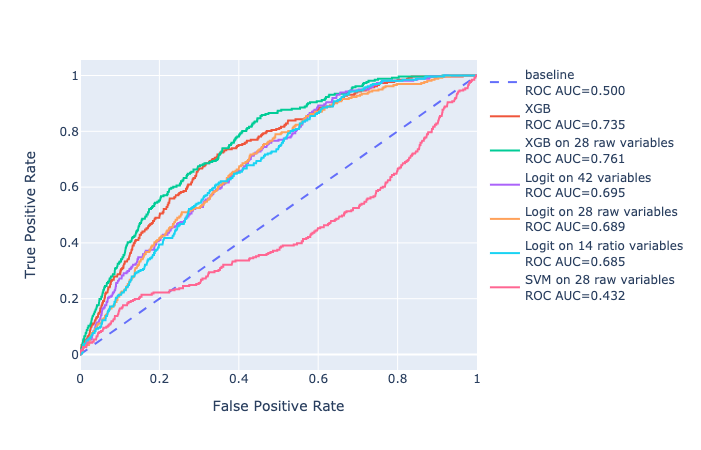

In [165]:
from matplotlib import pyplot

# generate probalilites for XGBoost classes
y_proba = model.predict_proba(X_test)
y_proba = y_proba[:,1]
#for the xgb model with 28 variables
y_proba_raw = model_raw.predict_proba(X_test_raw)
y_proba_raw = y_proba_raw[:,1]

# for the logit model
y_proba_logit = model_logit.predict_proba(X_test_imputed)
y_proba_logit = y_proba_logit[:,1]
#logit with 28
y_proba_logit_raw = model_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_raw = y_proba_logit_raw[:,1]
#logit with 14 financial ratios
y_proba_logit_ratio = model_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_ratio = y_proba_logit_ratio[:,1]

#for the svm model with 28 variables
y_proba_svm = model_svm.predict_proba(X_test_raw)
y_proba_svm = y_proba_svm[:,1]


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, y_proba)
xgb_raw_auc = roc_auc_score(y_test, y_proba_raw)
logit_auc = roc_auc_score(y_test, y_proba_logit)
logit_raw_auc = roc_auc_score(y_test, y_proba_logit_raw)
logit_ratio_auc = roc_auc_score(y_test, y_proba_logit_ratio)
svm_auc = roc_auc_score(y_test, y_proba_svm)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
print('XGB with 28 raw data variables: ROC AUC=%.3f' % (xgb_raw_auc))
print('Logit on 42: ROC AUC=%.3f' % (logit_auc))
print('Logit on 28: ROC AUC=%.3f' % (logit_raw_auc))
print('Logit on 14: ROC AUC=%.3f' % (logit_ratio_auc))
print('SVM on 28: ROC AUC=%.3f' % (svm_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_proba)
logit_fpr, logit_tpr, _ = roc_curve(y_test, y_proba_logit)
logit_raw_fpr, logit_raw_tpr, _ = roc_curve(y_test, y_proba_logit_raw)
logit_ratio_fpr, logit_r_tpr, _ = roc_curve(y_test, y_proba_logit_ratio)
xgb_raw_fpr, xgb_raw_tpr, _ = roc_curve(y_test, y_proba_raw)
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_proba_svm)

fig = px.line()
fig.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig.add_scatter(x=xgb_fpr, y=xgb_tpr, mode='lines', name='XGB<br>ROC AUC=%.3f' % (xgb_auc), hovertext='XGB')
fig.add_scatter(x=xgb_raw_fpr, y=xgb_raw_tpr, mode='lines', name='XGB on 28 raw variables<br>ROC AUC=%.3f' % (xgb_raw_auc))
fig.add_scatter(x=logit_fpr, y=logit_tpr, mode='lines', name='Logit on 42 variables<br>ROC AUC=%.3f' % (logit_auc))
fig.add_scatter(x=logit_raw_fpr, y=logit_raw_tpr, mode='lines', name='Logit on 28 raw variables<br>ROC AUC=%.3f' % (logit_raw_auc))
fig.add_scatter(x=logit_ratio_fpr, y=logit_ratio_tpr, mode='lines', name='Logit on 14 ratio variables<br>ROC AUC=%.3f' % (logit_ratio_auc))
fig.add_scatter(x=svm_fpr, y=svm_tpr, mode='lines', name='SVM on 28 raw variables <br>ROC AUC=%.3f' % (svm_auc))
fig.update_xaxes(title='False Positive Rate')
fig.update_yaxes(title='True Positive Rate')
fig.show()

# OLD plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
#pyplot.plot(xgb_fpr, xgb_tpr, marker='.', label='XGboost')
#pyplot.plot(logit_fpr, logit_tpr, marker='.', label='Logit')
#pyplot.plot(xgb_raw_fpr, xgb_raw_tpr, marker='.', label='XGBoost with 28 raw variables')
# axis labels
#pyplot.xlabel('False Positive Rate')
#pyplot.ylabel('True Positive Rate')
# show the legend
#pyplot.legend()
# show the plot
#pyplot.show()

In [25]:
y_proba_raw = model_raw.predict_proba(X_test_raw)
y_proba_raw = y_proba_raw[:,1]
xgb_raw_auc = roc_auc_score(y_test, y_proba_raw)
print('XGB with 28 raw data variables: ROC AUC=%.3f' % (xgb_raw_auc))

XGB with 28 raw data variables: ROC AUC=0.763


In [155]:
y_test_array = np.asarray(y_test)
y_test_array = y_test_array.flatten()
y_test_array = y_test_array.astype('int64')

#Sorting 
y_proba_inds = y_proba.argsort()
sorted_y_proba = y_proba[y_proba_inds[::-1]]
sorted_y_test = y_test_array[y_proba_inds[::-1]]

sorted_y_proba[0 : 352] = 1 
sorted_y_proba[353:35166] = 0
sorted_y_proba = sorted_y_proba.astype('int64')

y_proba = y_proba.astype('int64')

print('XGB Report of top 1% classification\n---\n ', classification_report(sorted_y_test, sorted_y_proba, digits=4))
print('XGB Report of with standard classifcation\n---\n ', classification_report(y_test, y_pred, digits=4))

cm1 = confusion_matrix(sorted_y_test, sorted_y_proba)
cm = confusion_matrix(y_test, y_pred)
print('XGB Confusion matrix with top 1% probabilites classfied as fraud \n', cm1)
print('XGB Confusion matrix with standard classification \n', cm)

##Same for the raw 28 variable model

y_proba_raw = model_raw.predict_proba(X_test_raw)
y_proba_raw = y_proba_raw[:,1]
y_proba_inds_raw = y_proba_raw.argsort()
sorted_y_proba_raw = y_proba_raw[y_proba_inds_raw[::-1]]
sorted_y_test_raw = y_test_array[y_proba_inds_raw[::-1]]
sorted_y_proba_raw[0 : 352] = 1 
sorted_y_proba_raw[353:35166] = 0
sorted_y_proba_raw = sorted_y_proba_raw.astype('int64')
y_proba_raw = y_proba.astype('int64')

print('XGB-28 Report of top 1% classification\n---\n ', classification_report(sorted_y_test_raw, sorted_y_proba_raw, digits=4))
print('XGB-28 Report of with standard classifcation\n---\n ', classification_report(y_test, y_pred_raw, digits=4))

cm_raw_sort = confusion_matrix(sorted_y_test_raw, sorted_y_proba_raw)
cm_raw = confusion_matrix(y_test, y_pred_raw)
print('XGB-28 Confusion matrix with top 1% probabilites classfied as fraud \n', cm_raw_sort,)
print('XGB-28 Confusion matrix with standard classification \n', cm_raw)


XGB Report of top 1% classification
---
                precision    recall  f1-score   support

           0     0.9928    0.9903    0.9916     34905
           1     0.0341    0.0460    0.0392       261

    accuracy                         0.9833     35166
   macro avg     0.5135    0.5181    0.5154     35166
weighted avg     0.9857    0.9833    0.9845     35166

XGB Report of with standard classifcation
---
                precision    recall  f1-score   support

           0     0.9928    0.9958    0.9943     34905
           1     0.0581    0.0345    0.0433       261

    accuracy                         0.9887     35166
   macro avg     0.5254    0.5151    0.5188     35166
weighted avg     0.9859    0.9887    0.9872     35166

XGB Confusion matrix with top 1% probabilites classfied as fraud 
 [[34565   340]
 [  249    12]]
XGB Confusion matrix with standard classification 
 [[34759   146]
 [  252     9]]
XGB-28 Report of top 1% classification
---
                precision    rec

In [156]:
#Reports for the Logit Models
# Sorting the to put the 352 predicitions with the highest proba on top. Logit on 42 variables
y_proba_logit_inds = y_proba_logit.argsort()
sorted_y_proba_logit = y_proba_logit[y_proba_logit_inds[::-1]]
sorted_y_test_logit = y_test_array[y_proba_logit_inds[::-1]]
sorted_y_proba_logit[0 : 352] = 1 
sorted_y_proba_logit[353:35166] = 0
sorted_y_proba_logit = sorted_y_proba_logit.astype('int64')
y_proba_logit = y_proba_logit.astype('int64')
#Logit on 28
y_proba_logit_raw_inds = y_proba_logit_raw.argsort()
sorted_y_proba_logit_raw = y_proba_logit_raw[y_proba_logit_raw_inds[::-1]]
sorted_y_test_logit_raw = y_test_array[y_proba_logit_raw_inds[::-1]]
sorted_y_proba_logit_raw[0 : 352] = 1 
sorted_y_proba_logit_raw[353:35166] = 0
sorted_y_proba_logit_raw = sorted_y_proba_logit_raw.astype('int64')
y_proba_logit_raw = y_proba_logit_raw.astype('int64')
#Logit on 14 ratio variables
y_proba_logit_ratio_inds = y_proba_logit_ratio.argsort()
sorted_y_proba_logit_ratio = y_proba_logit_ratio[y_proba_logit_ratio_inds[::-1]]
sorted_y_test_logit_ratio = y_test_array[y_proba_logit_ratio_inds[::-1]]
sorted_y_proba_logit_ratio[0 : 352] = 1 
sorted_y_proba_logit_ratio[353:35166] = 0
sorted_y_proba_logit_ratio = sorted_y_proba_logit_ratio.astype('int64')
y_proba_logit_ratio = y_proba_logit_ratio.astype('int64')

print('Logit-42 Report of top 1% classification\n---\n ', classification_report(sorted_y_test_logit, sorted_y_proba_logit, digits=4))
print('Logit-42 Report of with standard classifcation\n---\n ', classification_report(y_test, y_pred_logit, digits=4),'\n')

print('Logit-28 Report of top 1% classification\n---\n ', classification_report(sorted_y_test_logit_raw, sorted_y_proba_logit_raw, digits=4))
print('Logit-28 Report of with standard classifcation\n---\n ', classification_report(y_test, y_pred_logit_raw, digits=4),'\n')

print('Logit-14 Report of top 1% classification\n---\n ', classification_report(sorted_y_test_logit_ratio, sorted_y_proba_logit_ratio, digits=4))
print('Logit-14 Report of with standard classifcation\n---\n ', classification_report(y_test, y_pred_logit_ratio, digits=4))

print('Logit-42 1% Confusion matrix\n', confusion_matrix(sorted_y_test_logit, sorted_y_proba_logit))
print('Logit-28 1% Confusion matrix\n', confusion_matrix(sorted_y_test_logit_raw, sorted_y_proba_logit_raw))

print('Logit-42 STD Confusion matrix\n', confusion_matrix(y_test, y_pred_logit))
print('Logit-28 STD Confusion matrix\n', confusion_matrix(y_test, y_pred_logit_raw))

Logit-42 Report of top 1% classification
---
                precision    recall  f1-score   support

           0     0.9927    0.9901    0.9914     34905
           1     0.0199    0.0268    0.0228       261

    accuracy                         0.9830     35166
   macro avg     0.5063    0.5085    0.5071     35166
weighted avg     0.9855    0.9830    0.9842     35166

Logit-42 Report of with standard classifcation
---
                precision    recall  f1-score   support

           0     0.9926    0.9974    0.9950     34905
           1     0.0110    0.0038    0.0057       261

    accuracy                         0.9900     35166
   macro avg     0.5018    0.5006    0.5003     35166
weighted avg     0.9853    0.9900    0.9877     35166
 

Logit-28 Report of top 1% classification
---
                precision    recall  f1-score   support

           0     0.9927    0.9901    0.9914     34905
           1     0.0199    0.0268    0.0228       261

    accuracy                     

In [70]:
#Reports on the SVM-28
# Sorting the to put the 352 predicitions with the highest proba on top. 
y_proba_svm_inds = y_proba_svm.argsort()
sorted_y_proba_svm = y_proba_svm[y_proba_svm_inds[::-1]]
sorted_y_test_svm = y_test_array[y_proba_svm_inds[::-1]]
sorted_y_proba_svm[0 : 352] = 1 
sorted_y_proba_svm[353:35166] = 0
sorted_y_proba_svm = sorted_y_proba_svm.astype('int64')
y_proba_svm = y_proba_svm.astype('int64')

print('SVM-28 Report of top 1% classification\n---\n ', classification_report(sorted_y_test_svm, sorted_y_proba_svm, digits=4))
print('SVM-28 Report with standard classifcation\n---\n ', classification_report(y_test, y_pred_svm, digits=4))

SVM-28 Report of top 1% classification
---
                precision    recall  f1-score   support

           0     0.9929    0.9903    0.9916     34905
           1     0.0369    0.0498    0.0424       261

    accuracy                         0.9833     35166
   macro avg     0.5149    0.5200    0.5170     35166
weighted avg     0.9858    0.9833    0.9845     35166

SVM-28 Report with standard classifcation
---
                precision    recall  f1-score   support

           0     0.9926    0.9998    0.9962     34905
           1     0.1429    0.0038    0.0075       261

    accuracy                         0.9924     35166
   macro avg     0.5677    0.5018    0.5018     35166
weighted avg     0.9863    0.9924    0.9889     35166



In [78]:
#Bringing back the 1D arrays to 2D so NDCG_score can work with it
y_test_array2 = [y_test_array]
y_proba2 = [y_proba]
y_test_array_raw2 = [y_test_array]
y_proba_raw2 = [y_proba_raw]

sorted_y_test2 = [sorted_y_test]
sorted_y_test_raw2 = [sorted_y_test_raw]
sorted_y_test_logit2 = [sorted_y_test_logit]
sorted_y_test_logit_raw2 = [sorted_y_test_logit_raw]
sorted_y_test_logit_ratio2 = [sorted_y_test_logit_ratio]
sorted_y_test_svm2 = [sorted_y_test_svm]

sorted_y_proba2 = [sorted_y_proba]
sorted_y_proba_raw2 = [sorted_y_proba_raw]
sorted_y_proba_logit2 = [sorted_y_proba_logit]
sorted_y_proba_logit_raw2 = [sorted_y_proba_logit_raw]
sorted_y_proba_logit_ratio2 = [sorted_y_proba_logit_ratio]
sorted_y_proba_svm2 = [sorted_y_proba_svm]



In [168]:
#NDCG@k for XGB boost classification
print('XGB-42 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test2, sorted_y_proba2, k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@K=None, unsorted: ', sklearn.metrics.ndcg_score(y_test_array2, y_proba2, k=None, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@K=None, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test2, sorted_y_proba2, k=None, sample_weight=None, ignore_ties=False), '\n')

print('XGB-28 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_raw2, sorted_y_proba_raw2, k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@K=None, unsorted: ', sklearn.metrics.ndcg_score(y_test_array_raw2, y_proba_raw2, k=None, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@K=None, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_raw2, sorted_y_proba_raw2, k=None, sample_weight=None, ignore_ties=False), '\n')

#Logit NDCG@k
print('Logit-42 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_logit2, sorted_y_proba_logit2, k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_logit_raw2, sorted_y_proba_logit_raw2, k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_logit_ratio2, sorted_y_proba_logit_ratio2, k=352, sample_weight=None, ignore_ties=False),'\n')

#SVM NDCG@k
print('SVM-28 NDCG@top1%, sorted: ', sklearn.metrics.ndcg_score(sorted_y_test_svm2, sorted_y_proba_svm2, k=352, sample_weight=None, ignore_ties=False))

XGB-42 NDCG@top1%, sorted:  0.04291045243632971
XGB-42 NDCG@K=None, unsorted:  0.4559025188481433
XGB-42 NDCG@K=None, sorted:  0.4732469338554131 

XGB-28 NDCG@top1%, sorted:  0.050062194509051326
XGB-28 NDCG@K=None, unsorted:  0.4559025188481433
XGB-28 NDCG@K=None, sorted:  0.4769421580050899 

Logit-42 NDCG@top1%, sorted:  0.025031097254525663
Logit-28 NDCG@top1%, sorted:  0.025031097254525663
Logit-14 NDCG@top1%, sorted:  0.035758710363608094 

SVM-28 NDCG@top1%, sorted:  0.04648632347269052


### 5.3 XGBoost Evaluation on Augmented Dataset

No Skill: ROC AUC=0.500
XGB-42 at original data ROC AUC=0.735
XGB-42 at 1 percent fraud: ROC AUC=0.733
XGB-42 at 2 percent fraud ROC AUC=0.734
XGB-42 at 5 percent fraud ROC AUC=0.724
XGB-42 at 10 percent fraud ROC AUC=0.735
XGB-42 at 20 percent fraud ROC AUC=0.733


XGB-28 at original data ROC AUC=0.761
XGB-28 at 1 percent fraud ROC AUC=0.759
XGB-28 at 2 percent fraud ROC AUC=0.760
XGB-28 at 5 percent fraud ROC AUC=0.748
XGB-28 at 10 percent fraud ROC AUC=0.750
XGB-28 at 20 percent fraud ROC AUC=0.743


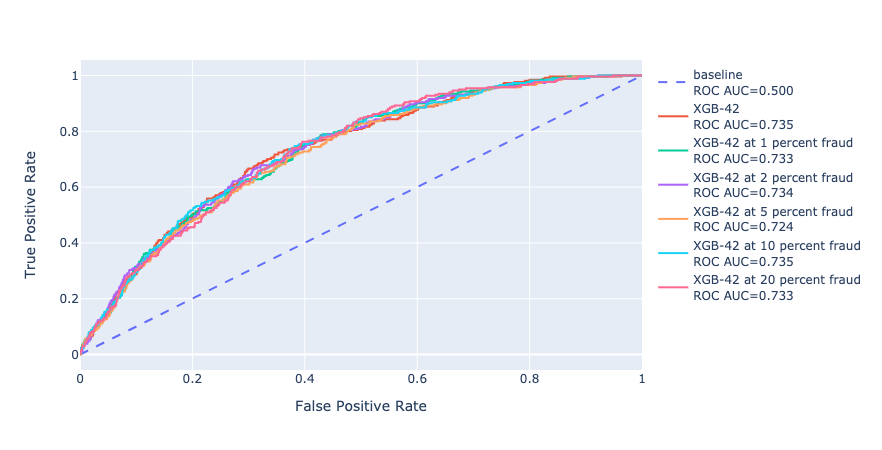

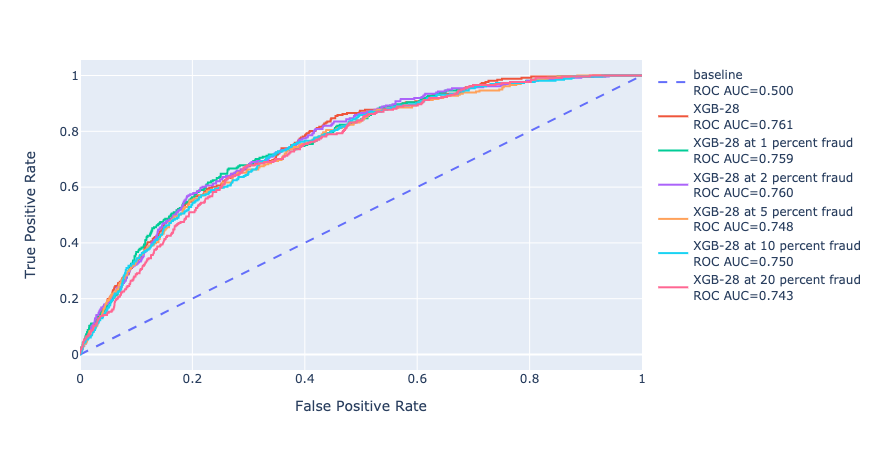

In [239]:
# generate probalilites for XGBoost on the full 42 variables and the varying fraud percentages
#At 1% fraud
y_proba_1p = model1p.predict_proba(X_test)
y_proba_1p = y_proba_1p[:,1]
#2% fraud
y_proba_2p = model2p.predict_proba(X_test)
y_proba_2p = y_proba_2p[:,1]
#5% fraud
y_proba_5p = model5p.predict_proba(X_test)
y_proba_5p = y_proba_5p[:,1]
#10% fraud
y_proba_10p = model10p.predict_proba(X_test)
y_proba_10p = y_proba_10p[:,1]
#20% fraud
y_proba_20p = model20p.predict_proba(X_test)
y_proba_20p = y_proba_20p[:,1]

#Same for the raw 28 variable version
#At 1% fraud
y_proba_1p_raw = model1p_raw.predict_proba(X_test_raw)
y_proba_1p_raw = y_proba_1p_raw[:,1]
#2% fraud
y_proba_2p_raw = model2p_raw.predict_proba(X_test_raw)
y_proba_2p_raw = y_proba_2p_raw[:,1]
#5% fraud
y_proba_5p_raw = model5p_raw.predict_proba(X_test_raw)
y_proba_5p_raw = y_proba_5p_raw[:,1]
#10% fraud
y_proba_10p_raw = model10p_raw.predict_proba(X_test_raw)
y_proba_10p_raw = y_proba_10p_raw[:,1]
#20% fraud
y_proba_20p_raw = model20p_raw.predict_proba(X_test_raw)
y_proba_20p_raw = y_proba_20p_raw[:,1]


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_1p_auc = roc_auc_score(y_test, y_proba_1p)
xgb_2p_auc = roc_auc_score(y_test, y_proba_2p)
xgb_5p_auc = roc_auc_score(y_test, y_proba_5p)
xgb_10p_auc = roc_auc_score(y_test, y_proba_10p)
xgb_20p_auc = roc_auc_score(y_test, y_proba_20p)

xgb_1p_raw_auc = roc_auc_score(y_test, y_proba_1p_raw)
xgb_2p_raw_auc = roc_auc_score(y_test, y_proba_2p_raw)
xgb_5p_raw_auc = roc_auc_score(y_test, y_proba_5p_raw)
xgb_10p_raw_auc = roc_auc_score(y_test, y_proba_10p_raw)
xgb_20p_raw_auc = roc_auc_score(y_test, y_proba_20p_raw)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB-42 at original data ROC AUC=%.3f' % (xgb_auc))
print('XGB-42 at 1 percent fraud: ROC AUC=%.3f' % (xgb_1p_auc))
print('XGB-42 at 2 percent fraud ROC AUC=%.3f' % (xgb_2p_auc))
print('XGB-42 at 5 percent fraud ROC AUC=%.3f' % (xgb_5p_auc))
print('XGB-42 at 10 percent fraud ROC AUC=%.3f' % (xgb_10p_auc))
print('XGB-42 at 20 percent fraud ROC AUC=%.3f' % (xgb_20p_auc))
print('\n')
print('XGB-28 at original data ROC AUC=%.3f' % (xgb_raw_auc))
print('XGB-28 at 1 percent fraud ROC AUC=%.3f' % (xgb_1p_raw_auc))
print('XGB-28 at 2 percent fraud ROC AUC=%.3f' % (xgb_2p_raw_auc))
print('XGB-28 at 5 percent fraud ROC AUC=%.3f' % (xgb_5p_raw_auc))
print('XGB-28 at 10 percent fraud ROC AUC=%.3f' % (xgb_10p_raw_auc))
print('XGB-28 at 20 percent fraud ROC AUC=%.3f' % (xgb_20p_raw_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_1p_fpr, xgb_1p_tpr, _ = roc_curve(y_test, y_proba_1p)
xgb_2p_fpr, xgb_2p_tpr, _ = roc_curve(y_test, y_proba_2p)
xgb_5p_fpr, xgb_5p_tpr, _ = roc_curve(y_test, y_proba_5p)
xgb_10p_fpr, xgb_10p_tpr, _ = roc_curve(y_test, y_proba_10p)
xgb_20p_fpr, xgb_20p_tpr, _ = roc_curve(y_test, y_proba_20p)

xgb_1p_raw_fpr, xgb_1p_raw_tpr, _ = roc_curve(y_test, y_proba_1p_raw)
xgb_2p_raw_fpr, xgb_2p_raw_tpr, _ = roc_curve(y_test, y_proba_2p_raw)
xgb_5p_raw_fpr, xgb_5p_raw_tpr, _ = roc_curve(y_test, y_proba_5p_raw)
xgb_10p_raw_fpr, xgb_10p_raw_tpr, _ = roc_curve(y_test, y_proba_10p_raw)
xgb_20p_raw_fpr, xgb_20p_raw_tpr, _ = roc_curve(y_test, y_proba_20p_raw)

fig = px.line()
fig.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig.add_scatter(x=xgb_fpr, y=xgb_tpr, mode='lines', name='XGB-42 <br>ROC AUC=%.3f' % (xgb_auc), hovertext='XGB')
fig.add_scatter(x=xgb_1p_fpr, y=xgb_1p_tpr, mode='lines', name='XGB-42 at 1 percent fraud <br>ROC AUC=%.3f' % (xgb_1p_auc), hovertext='XGB1p')
fig.add_scatter(x=xgb_2p_fpr, y=xgb_2p_tpr, mode='lines', name='XGB-42 at 2 percent fraud <br>ROC AUC=%.3f' % (xgb_2p_auc), hovertext='XGB2p')
fig.add_scatter(x=xgb_5p_fpr, y=xgb_5p_tpr, mode='lines', name='XGB-42 at 5 percent fraud <br>ROC AUC=%.3f' % (xgb_5p_auc), hovertext='XGB5p')
fig.add_scatter(x=xgb_10p_fpr, y=xgb_10p_tpr, mode='lines', name='XGB-42 at 10 percent fraud <br>ROC AUC=%.3f' % (xgb_10p_auc), hovertext='XGB10p')
fig.add_scatter(x=xgb_20p_fpr, y=xgb_20p_tpr, mode='lines', name='XGB-42 at 20 percent fraud <br>ROC AUC=%.3f' % (xgb_20p_auc), hovertext='XGB20p')
fig.update_xaxes(title='False Positive Rate')
fig.update_yaxes(title='True Positive Rate')
fig.show()

fig_raw = px.line()
fig_raw.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig_raw.add_scatter(x=xgb_raw_fpr, y=xgb_raw_tpr, mode='lines', name='XGB-28<br>ROC AUC=%.3f' % (xgb_raw_auc), hovertext='XGB')
fig_raw.add_scatter(x=xgb_1p_raw_fpr, y=xgb_1p_raw_tpr, mode='lines', name='XGB-28 at 1 percent fraud <br>ROC AUC=%.3f' % (xgb_1p_raw_auc), hovertext='XGB1p')
fig_raw.add_scatter(x=xgb_2p_raw_fpr, y=xgb_2p_raw_tpr, mode='lines', name='XGB-28 at 2 percent fraud <br>ROC AUC=%.3f' % (xgb_2p_raw_auc), hovertext='XGB2p')
fig_raw.add_scatter(x=xgb_5p_raw_fpr, y=xgb_5p_raw_tpr, mode='lines', name='XGB-28 at 5 percent fraud <br>ROC AUC=%.3f' % (xgb_5p_raw_auc), hovertext='XGB5p')
fig_raw.add_scatter(x=xgb_10p_raw_fpr, y=xgb_10p_raw_tpr, mode='lines', name='XGB-28 at 10 percent fraud <br>ROC AUC=%.3f' % (xgb_10p_raw_auc), hovertext='XGB10p')
fig_raw.add_scatter(x=xgb_20p_raw_fpr, y=xgb_20p_raw_tpr, mode='lines', name='XGB-28 at 20 percent fraud <br>ROC AUC=%.3f' % (xgb_20p_raw_auc), hovertext='XGB20p')
fig_raw.update_xaxes(title='False Positive Rate')
fig_raw.update_yaxes(title='True Positive Rate')
fig_raw.show()

In [240]:
y_test_array = np.asarray(y_test)
y_test_array = y_test_array.flatten()
y_test_array = y_test_array.astype('int64')


#Sorting the individual classifications
#XGB-42 at 1%
y_proba_1p_inds = y_proba_1p.argsort()
sorted_y_proba_1p = y_proba_1p[y_proba_1p_inds[::-1]]
sorted_y_test_1p = y_test_array[y_proba_1p_inds[::-1]]
sorted_y_proba_1p[0 : 352] = 1 
sorted_y_proba_1p[353:35166] = 0
sorted_y_proba_1p = sorted_y_proba_1p.astype('int64')
#At 2%
y_proba_2p_inds = y_proba_2p.argsort()
sorted_y_proba_2p = y_proba_2p[y_proba_2p_inds[::-1]]
sorted_y_test_2p = y_test_array[y_proba_2p_inds[::-1]]
sorted_y_proba_2p[0 : 352] = 1 
sorted_y_proba_2p[353:35166] = 0
sorted_y_proba_2p = sorted_y_proba_2p.astype('int64')
#5%
y_proba_5p_inds = y_proba_5p.argsort()
sorted_y_proba_5p = y_proba_5p[y_proba_5p_inds[::-1]]
sorted_y_test_5p = y_test_array[y_proba_5p_inds[::-1]]
sorted_y_proba_5p[0 : 352] = 1 
sorted_y_proba_5p[353:35166] = 0
sorted_y_proba_5p = sorted_y_proba_5p.astype('int64')
#10%
y_proba_10p_inds = y_proba_10p.argsort()
sorted_y_proba_10p = y_proba_10p[y_proba_10p_inds[::-1]]
sorted_y_test_10p = y_test_array[y_proba_10p_inds[::-1]]
sorted_y_proba_10p[0 : 352] = 1 
sorted_y_proba_10p[353:35166] = 0
sorted_y_proba_10p = sorted_y_proba_10p.astype('int64')
#20%
y_proba_20p_inds = y_proba_20p.argsort()
sorted_y_proba_20p = y_proba_20p[y_proba_20p_inds[::-1]]
sorted_y_test_20p = y_test_array[y_proba_20p_inds[::-1]]
sorted_y_proba_20p[0 : 352] = 1 
sorted_y_proba_20p[353:35166] = 0
sorted_y_proba_20p = sorted_y_proba_20p.astype('int64')

#The same for XGB-28
y_proba_1p_raw_inds = y_proba_1p_raw.argsort()
sorted_y_proba_1p_raw = y_proba_1p_raw[y_proba_1p_raw_inds[::-1]]
sorted_y_test_1p_raw = y_test_array[y_proba_1p_raw_inds[::-1]]
sorted_y_proba_1p_raw[0 : 352] = 1 
sorted_y_proba_1p_raw[353:35166] = 0
sorted_y_proba_1p_raw = sorted_y_proba_1p_raw.astype('int64')
#At 2%
y_proba_2p_raw_inds = y_proba_2p_raw.argsort()
sorted_y_proba_2p_raw = y_proba_2p_raw[y_proba_2p_raw_inds[::-1]]
sorted_y_test_2p_raw = y_test_array[y_proba_2p_raw_inds[::-1]]
sorted_y_proba_2p_raw[0 : 352] = 1 
sorted_y_proba_2p_raw[353:35166] = 0
sorted_y_proba_2p_raw = sorted_y_proba_2p_raw.astype('int64')
#5%
y_proba_5p_raw_inds = y_proba_5p_raw.argsort()
sorted_y_proba_5p_raw = y_proba_5p_raw[y_proba_5p_inds[::-1]]
sorted_y_test_5p_raw = y_test_array[y_proba_5p_raw_inds[::-1]]
sorted_y_proba_5p_raw[0 : 352] = 1 
sorted_y_proba_5p_raw[353:35166] = 0
sorted_y_proba_5p_raw = sorted_y_proba_5p_raw.astype('int64')
#10%
y_proba_10p_raw_inds = y_proba_10p_raw.argsort()
sorted_y_proba_10p_raw = y_proba_10p_raw[y_proba_10p_raw_inds[::-1]]
sorted_y_test_10p_raw = y_test_array[y_proba_10p_raw_inds[::-1]]
sorted_y_proba_10p_raw[0 : 352] = 1 
sorted_y_proba_10p_raw[353:35166] = 0
sorted_y_proba_10p_raw = sorted_y_proba_10p_raw.astype('int64')
#20%
y_proba_20p_raw_inds = y_proba_20p_raw.argsort()
sorted_y_proba_20p_raw = y_proba_20p_raw[y_proba_20p_raw_inds[::-1]]
sorted_y_test_20p_raw = y_test_array[y_proba_20p_raw_inds[::-1]]
sorted_y_proba_20p_raw[0 : 352] = 1 
sorted_y_proba_20p_raw[353:35166] = 0
sorted_y_proba_20p_raw = sorted_y_proba_20p_raw.astype('int64')

print('XGB-42 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_1p, sorted_y_proba_1p, digits=4))
print('XGB-42 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_2p, sorted_y_proba_2p, digits=4))
print('XGB-42 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_5p, sorted_y_proba_5p, digits=4))
print('XGB-42 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_10p, sorted_y_proba_10p, digits=4))
print('XGB-42 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_20p, sorted_y_proba_20p, digits=4))
print('----------')
print('XGB-28 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_1p_raw, sorted_y_proba_1p_raw, digits=4))
print('XGB-28 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_2p_raw, sorted_y_proba_2p_raw, digits=4))
print('XGB-28 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_5p_raw, sorted_y_proba_5p_raw, digits=4))
print('XGB-28 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_10p_raw, sorted_y_proba_10p_raw, digits=4))
print('XGB-28 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_20p_raw, sorted_y_proba_20p_raw, digits=4))


XGB-42 at 1% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9929    0.9903    0.9916     34905
           1     0.0398    0.0536    0.0457       261

    accuracy                         0.9834     35166
   macro avg     0.5163    0.5220    0.5186     35166
weighted avg     0.9858    0.9834    0.9846     35166

XGB-42 at 2% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9928    0.9902    0.9915     34905
           1     0.0284    0.0383    0.0326       261

    accuracy                         0.9831     35166
   macro avg     0.5106    0.5143    0.5121     35166
weighted avg     0.9856    0.9831    0.9844     35166

XGB-42 at 5% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9929    0.9903    0.9916     34905
           1     0.0398    0.0536    0.0457       261

    accuracy                         0.9834     35166
   macro avg     0.5163    0.

In [251]:
print('XGB-42 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test], [sorted_y_proba], k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_1p], [sorted_y_proba_1p], k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_2p], [sorted_y_proba_2p], k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_5p], [sorted_y_proba_5p], k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_10p], [sorted_y_proba_10p], k=352, sample_weight=None, ignore_ties=False))
print('XGB-42 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_20p], [sorted_y_proba_20p], k=352, sample_weight=None, ignore_ties=False))
print('-----')
print('XGB-28 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test_raw], [sorted_y_proba_raw], k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_1p_raw], [sorted_y_proba_1p_raw], k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_2p_raw], [sorted_y_proba_2p_raw], k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_5p_raw], [sorted_y_proba_5p_raw], k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_10p_raw], [sorted_y_proba_10p_raw], k=352, sample_weight=None, ignore_ties=False))
print('XGB-28 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_20p_raw], [sorted_y_proba_20p_raw], k=352, sample_weight=None, ignore_ties=False))

XGB-42 NDCG@top1%, sorted baseline:  0.04291045243632971
XGB-42 NDCG@top1%, sorted @ 1% fraud:  0.050062194509051326
XGB-42 NDCG@top1%, sorted @ 2% fraud:  0.035758710363608094
XGB-42 NDCG@top1%, sorted @ 5% fraud:  0.050062194509051326
XGB-42 NDCG@top1%, sorted @ 10% fraud:  0.0393345813999689
XGB-42 NDCG@top1%, sorted @ 20% fraud:  0.0393345813999689
-----
XGB-28 NDCG@top1%, sorted baseline:  0.050062194509051326
XGB-28 NDCG@top1%, sorted @ 1% fraud:  0.057213936581772956
XGB-28 NDCG@top1%, sorted @ 2% fraud:  0.035758710363608094
XGB-28 NDCG@top1%, sorted @ 5% fraud:  0.0393345813999689
XGB-28 NDCG@top1%, sorted @ 10% fraud:  0.04291045243632971
XGB-28 NDCG@top1%, sorted @ 20% fraud:  0.050062194509051326


### 5.4 Logit model evaluation on augmented dataset

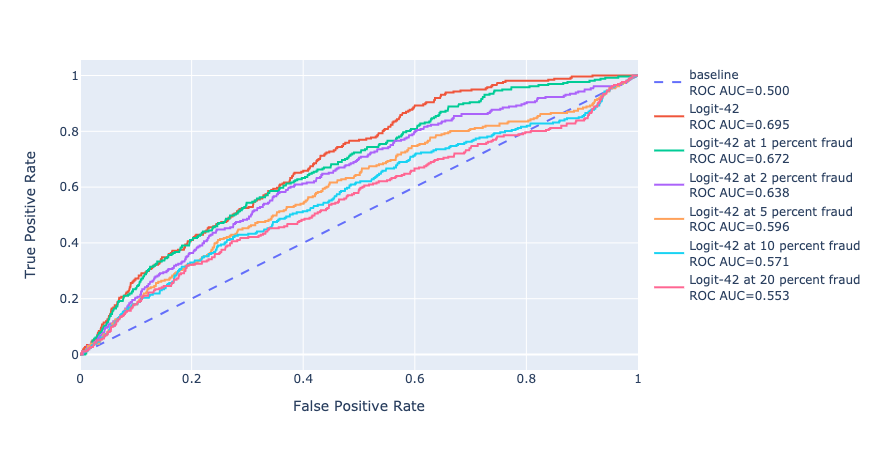

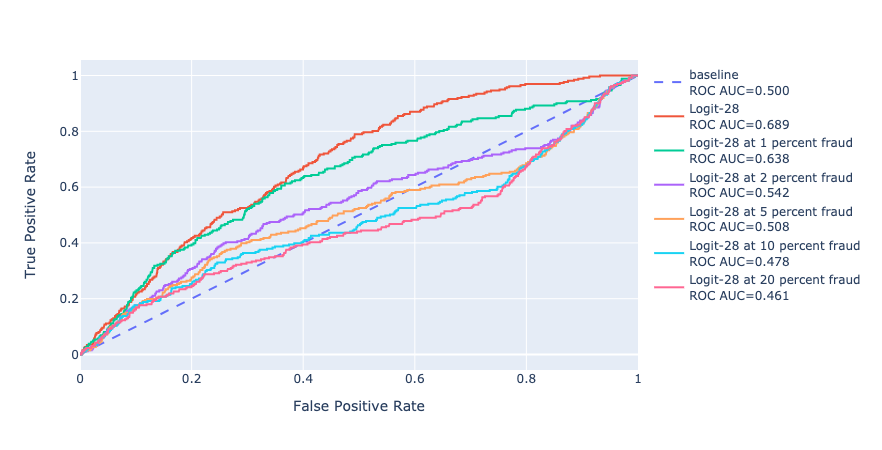

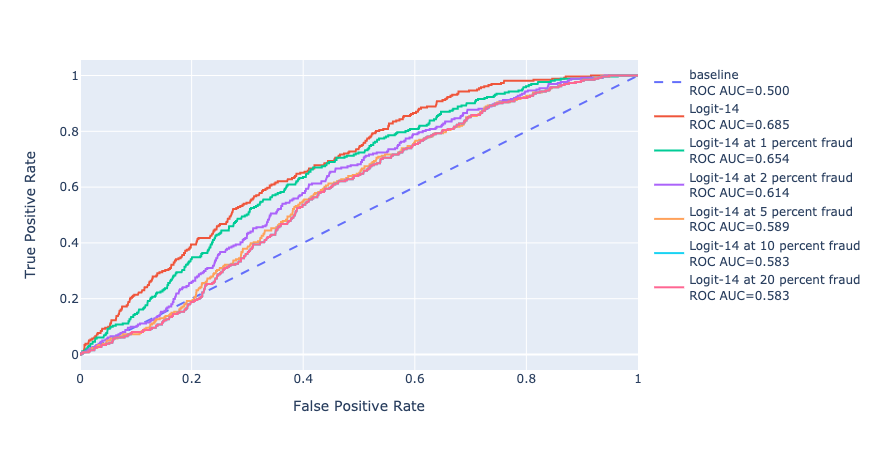

In [242]:
# generate probalilites for the Logit Model on the full 42 variables and the varying fraud percentages
y_proba_logit_1p = model1p_logit.predict_proba(X_test_imputed)
y_proba_logit_1p = y_proba_logit_1p[:,1]
#2% fraud
y_proba_logit_2p = model2p_logit.predict_proba(X_test_imputed)
y_proba_logit_2p= y_proba_logit_2p[:,1]
#5% fraud
y_proba_logit_5p = model5p_logit.predict_proba(X_test_imputed)
y_proba_logit_5p = y_proba_logit_5p[:,1]
#10% fraud
y_proba_logit_10p = model10p_logit.predict_proba(X_test_imputed)
y_proba_logit_10p = y_proba_logit_10p[:,1]
#20% fraud
y_proba_logit_20p = model20p_logit.predict_proba(X_test_imputed)
y_proba_logit_20p = y_proba_logit_20p[:,1]

#Logit on 28
#At 1% fraud
y_proba_logit_1p_raw = model1p_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_1p_raw = y_proba_logit_1p_raw[:,1]
#2% fraud
y_proba_logit_2p_raw = model2p_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_2p_raw = y_proba_logit_2p_raw[:,1]
#5% fraud
y_proba_logit_5p_raw = model5p_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_5p_raw = y_proba_logit_5p_raw[:,1]
#10% fraud
y_proba_logit_10p_raw = model10p_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_10p_raw = y_proba_logit_10p_raw[:,1]
#20% fraud
y_proba_logit_20p_raw = model20p_logit_raw.predict_proba(X_test_raw_imputed)
y_proba_logit_20p_raw = y_proba_logit_20p_raw[:,1]

#Logit on 14
#At 1% fraud
y_proba_logit_1p_ratio = model1p_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_1p_ratio = y_proba_logit_1p_ratio[:,1]
#2% fraud
y_proba_logit_2p_ratio = model2p_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_2p_ratio = y_proba_logit_2p_ratio[:,1]
#5% fraud
y_proba_logit_5p_ratio = model5p_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_5p_ratio = y_proba_logit_5p_ratio[:,1]
#10% fraud
y_proba_logit_10p_ratio = model10p_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_10p_ratio = y_proba_logit_10p_ratio[:,1]
#20% fraud
y_proba_logit_20p_ratio = model20p_logit_ratio.predict_proba(X_test_ratio_imputed)
y_proba_logit_20p_ratio = y_proba_logit_20p_ratio[:,1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
logit_1p_auc = roc_auc_score(y_test, y_proba_logit_1p)
logit_2p_auc = roc_auc_score(y_test, y_proba_logit_2p)
logit_5p_auc = roc_auc_score(y_test, y_proba_logit_5p)
logit_10p_auc = roc_auc_score(y_test, y_proba_logit_10p)
logit_20p_auc = roc_auc_score(y_test, y_proba_logit_20p)
#28 var
logit_1p_raw_auc = roc_auc_score(y_test, y_proba_logit_1p_raw)
logit_2p_raw_auc = roc_auc_score(y_test, y_proba_logit_2p_raw)
logit_5p_raw_auc = roc_auc_score(y_test, y_proba_logit_5p_raw)
logit_10p_raw_auc = roc_auc_score(y_test, y_proba_logit_10p_raw)
logit_20p_raw_auc = roc_auc_score(y_test, y_proba_logit_20p_raw)
#14 var
logit_1p_ratio_auc = roc_auc_score(y_test, y_proba_logit_1p_ratio)
logit_2p_ratio_auc = roc_auc_score(y_test, y_proba_logit_2p_ratio)
logit_5p_ratio_auc = roc_auc_score(y_test, y_proba_logit_5p_ratio)
logit_10p_ratio_auc = roc_auc_score(y_test, y_proba_logit_10p_ratio)
logit_20p_ratio_auc = roc_auc_score(y_test, y_proba_logit_20p_ratio)

#Calculating scores for 
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logit_1p_fpr, logit_1p_tpr, _ = roc_curve(y_test, y_proba_logit_1p)
logit_2p_fpr, logit_2p_tpr, _ = roc_curve(y_test, y_proba_logit_2p)
logit_5p_fpr, logit_5p_tpr, _ = roc_curve(y_test, y_proba_logit_5p)
logit_10p_fpr, logit_10p_tpr, _ = roc_curve(y_test, y_proba_logit_10p)
logit_20p_fpr, logit_20p_tpr, _ = roc_curve(y_test, y_proba_logit_20p)

logit_1p_raw_fpr, logit_1p_raw_tpr, _ = roc_curve(y_test, y_proba_logit_1p_raw)
logit_2p_raw_fpr, logit_2p_raw_tpr, _ = roc_curve(y_test, y_proba_logit_2p_raw)
logit_5p_raw_fpr, logit_5p_raw_tpr, _ = roc_curve(y_test, y_proba_logit_5p_raw)
logit_10p_raw_fpr, logit_10p_raw_tpr, _ = roc_curve(y_test, y_proba_logit_10p_raw)
logit_20p_raw_fpr, logit_20p_raw_tpr, _ = roc_curve(y_test, y_proba_logit_20p_raw)

logit_1p_ratio_fpr, logit_1p_ratio_tpr, _ = roc_curve(y_test, y_proba_logit_1p_ratio)
logit_2p_ratio_fpr, logit_2p_ratio_tpr, _ = roc_curve(y_test, y_proba_logit_2p_ratio)
logit_5p_ratio_fpr, logit_5p_ratio_tpr, _ = roc_curve(y_test, y_proba_logit_5p_ratio)
logit_10p_ratio_fpr, logit_10p_ratio_tpr, _ = roc_curve(y_test, y_proba_logit_10p_ratio)
logit_20p_ratio_fpr, logit_20p_ratio_tpr, _ = roc_curve(y_test, y_proba_logit_20p_ratio)

fig_logit = px.line()
fig_logit.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig_logit.add_scatter(x=logit_fpr, y=logit_tpr, mode='lines', name='Logit-42 <br>ROC AUC=%.3f' % (logit_auc), hovertext='Logit-42')
fig_logit.add_scatter(x=logit_1p_fpr, y=logit_1p_tpr, mode='lines', name='Logit-42 at 1 percent fraud <br>ROC AUC=%.3f' % (logit_1p_auc), hovertext='Logit1p')
fig_logit.add_scatter(x=logit_2p_fpr, y=logit_2p_tpr, mode='lines', name='Logit-42 at 2 percent fraud <br>ROC AUC=%.3f' % (logit_2p_auc), hovertext='Logit2p')
fig_logit.add_scatter(x=logit_5p_fpr, y=logit_5p_tpr, mode='lines', name='Logit-42 at 5 percent fraud <br>ROC AUC=%.3f' % (logit_5p_auc), hovertext='Logit5p')
fig_logit.add_scatter(x=logit_10p_fpr, y=logit_10p_tpr, mode='lines', name='Logit-42 at 10 percent fraud <br>ROC AUC=%.3f' % (logit_10p_auc), hovertext='Logit10p')
fig_logit.add_scatter(x=logit_20p_fpr, y=logit_20p_tpr, mode='lines', name='Logit-42 at 20 percent fraud <br>ROC AUC=%.3f' % (logit_20p_auc), hovertext='Logit20p')
fig_logit.update_xaxes(title='False Positive Rate')
fig_logit.update_yaxes(title='True Positive Rate')
fig_logit.show()

fig_logit_raw = px.line()
fig_logit_raw.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig_logit_raw.add_scatter(x=logit_raw_fpr, y=logit_raw_tpr, mode='lines', name='Logit-28 <br>ROC AUC=%.3f' % (logit_raw_auc), hovertext='Logit-28')
fig_logit_raw.add_scatter(x=logit_1p_raw_fpr, y=logit_1p_raw_tpr, mode='lines', name='Logit-28 at 1 percent fraud <br>ROC AUC=%.3f' % (logit_1p_raw_auc), hovertext='Logit1p')
fig_logit_raw.add_scatter(x=logit_2p_raw_fpr, y=logit_2p_raw_tpr, mode='lines', name='Logit-28 at 2 percent fraud <br>ROC AUC=%.3f' % (logit_2p_raw_auc), hovertext='Logit2p')
fig_logit_raw.add_scatter(x=logit_5p_raw_fpr, y=logit_5p_raw_tpr, mode='lines', name='Logit-28 at 5 percent fraud <br>ROC AUC=%.3f' % (logit_5p_raw_auc), hovertext='Logit5p')
fig_logit_raw.add_scatter(x=logit_10p_raw_fpr, y=logit_10p_raw_tpr, mode='lines', name='Logit-28 at 10 percent fraud <br>ROC AUC=%.3f' % (logit_10p_raw_auc), hovertext='Logit10p')
fig_logit_raw.add_scatter(x=logit_20p_raw_fpr, y=logit_20p_raw_tpr, mode='lines', name='Logit-28 at 20 percent fraud <br>ROC AUC=%.3f' % (logit_20p_raw_auc), hovertext='Logit20p')
fig_logit_raw.update_xaxes(title='False Positive Rate')
fig_logit_raw.update_yaxes(title='True Positive Rate')
fig_logit_raw.show()

fig_logit_ratio = px.line()
fig_logit_ratio.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig_logit_ratio.add_scatter(x=logit_ratio_fpr, y=logit_ratio_tpr, mode='lines', name='Logit-14 <br>ROC AUC=%.3f' % (logit_ratio_auc), hovertext='Logit-28')
fig_logit_ratio.add_scatter(x=logit_1p_ratio_fpr, y=logit_1p_ratio_tpr, mode='lines', name='Logit-14 at 1 percent fraud <br>ROC AUC=%.3f' % (logit_1p_ratio_auc), hovertext='Logit1p')
fig_logit_ratio.add_scatter(x=logit_2p_ratio_fpr, y=logit_2p_ratio_tpr, mode='lines', name='Logit-14 at 2 percent fraud <br>ROC AUC=%.3f' % (logit_2p_ratio_auc), hovertext='Logit2p')
fig_logit_ratio.add_scatter(x=logit_5p_ratio_fpr, y=logit_5p_ratio_tpr, mode='lines', name='Logit-14 at 5 percent fraud <br>ROC AUC=%.3f' % (logit_5p_ratio_auc), hovertext='Logit5p')
fig_logit_ratio.add_scatter(x=logit_10p_ratio_fpr, y=logit_10p_ratio_tpr, mode='lines', name='Logit-14 at 10 percent fraud <br>ROC AUC=%.3f' % (logit_10p_ratio_auc), hovertext='Logit10p')
fig_logit_ratio.add_scatter(x=logit_20p_ratio_fpr, y=logit_20p_ratio_tpr, mode='lines', name='Logit-14 at 20 percent fraud <br>ROC AUC=%.3f' % (logit_20p_ratio_auc), hovertext='Logit20p')
fig_logit_ratio.update_xaxes(title='False Positive Rate')
fig_logit_ratio.update_yaxes(title='True Positive Rate')
fig_logit_ratio.show()


In [243]:
#Sorting the individual classifications
#Logit-42 at 1%
y_proba_logit_1p_inds = y_proba_logit_1p.argsort()
sorted_y_proba_logit_1p = y_proba_logit_1p[y_proba_logit_1p_inds[::-1]]
sorted_y_test_logit_1p = y_test_array[y_proba_logit_1p_inds[::-1]]
sorted_y_proba_logit_1p[0 : 352] = 1 
sorted_y_proba_logit_1p[353:35166] = 0
sorted_y_proba_logit_1p = sorted_y_proba_logit_1p.astype('int64')
#At 2%
y_proba_logit_2p_inds = y_proba_logit_2p.argsort()
sorted_y_proba_logit_2p = y_proba_logit_2p[y_proba_logit_2p_inds[::-1]]
sorted_y_test_logit_2p = y_test_array[y_proba_logit_2p_inds[::-1]]
sorted_y_proba_logit_2p[0 : 352] = 1 
sorted_y_proba_logit_2p[353:35166] = 0
sorted_y_proba_logit_2p = sorted_y_proba_logit_2p.astype('int64')
#5%
y_proba_logit_5p_inds = y_proba_logit_5p.argsort()
sorted_y_proba_logit_5p = y_proba_logit_5p[y_proba_logit_5p_inds[::-1]]
sorted_y_test_logit_5p = y_test_array[y_proba_logit_5p_inds[::-1]]
sorted_y_proba_logit_5p[0 : 352] = 1 
sorted_y_proba_logit_5p[353:35166] = 0
sorted_y_proba_logit_5p = sorted_y_proba_logit_5p.astype('int64')
#10%
y_proba_logit_10p_inds = y_proba_logit_10p.argsort()
sorted_y_proba_logit_10p = y_proba_logit_10p[y_proba_logit_10p_inds[::-1]]
sorted_y_test_logit_10p = y_test_array[y_proba_logit_10p_inds[::-1]]
sorted_y_proba_logit_10p[0 : 352] = 1 
sorted_y_proba_logit_10p[353:35166] = 0
sorted_y_proba_logit_10p = sorted_y_proba_logit_10p.astype('int64')
#20%
y_proba_logit_20p_inds = y_proba_logit_20p.argsort()
sorted_y_proba_logit_20p = y_proba_logit_20p[y_proba_logit_20p_inds[::-1]]
sorted_y_test_logit_20p = y_test_array[y_proba_logit_20p_inds[::-1]]
sorted_y_proba_logit_20p[0 : 352] = 1 
sorted_y_proba_logit_20p[353:35166] = 0
sorted_y_proba_logit_20p = sorted_y_proba_logit_20p.astype('int64')

#The same for Logit-28
y_proba_logit_1p_raw_inds = y_proba_logit_1p_raw.argsort()
sorted_y_proba_logit_1p_raw = y_proba_logit_1p_raw[y_proba_logit_1p_raw_inds[::-1]]
sorted_y_test_logit_1p_raw = y_test_array[y_proba_logit_1p_raw_inds[::-1]]
sorted_y_proba_logit_1p_raw[0 : 352] = 1 
sorted_y_proba_logit_1p_raw[353:35166] = 0
sorted_y_proba_logit_1p_raw = sorted_y_proba_logit_1p_raw.astype('int64')
#At 2%
y_proba_logit_2p_raw_inds = y_proba_logit_2p_raw.argsort()
sorted_y_proba_logit_2p_raw = y_proba_logit_2p_raw[y_proba_logit_2p_raw_inds[::-1]]
sorted_y_test_logit_2p_raw = y_test_array[y_proba_logit_2p_raw_inds[::-1]]
sorted_y_proba_logit_2p_raw[0 : 352] = 1 
sorted_y_proba_logit_2p_raw[353:35166] = 0
sorted_y_proba_logit_2p_raw = sorted_y_proba_logit_2p_raw.astype('int64')
#5%
y_proba_logit_5p_raw_inds = y_proba_logit_5p_raw.argsort()
sorted_y_proba_logit_5p_raw = y_proba_logit_5p_raw[y_proba_logit_5p_raw_inds[::-1]]
sorted_y_test_logit_5p_raw = y_test_array[y_proba_logit_5p_raw_inds[::-1]]
sorted_y_proba_logit_5p_raw[0 : 352] = 1 
sorted_y_proba_logit_5p_raw[353:35166] = 0
sorted_y_proba_logit_5p_raw = sorted_y_proba_logit_5p_raw.astype('int64')
#10%
y_proba_logit_10p_raw_inds = y_proba_logit_10p_raw.argsort()
sorted_y_proba_logit_10p_raw = y_proba_logit_10p_raw[y_proba_logit_10p_raw_inds[::-1]]
sorted_y_test_logit_10p_raw = y_test_array[y_proba_logit_10p_raw_inds[::-1]]
sorted_y_proba_logit_10p_raw[0 : 352] = 1 
sorted_y_proba_logit_10p_raw[353:35166] = 0
sorted_y_proba_logit_10p_raw = sorted_y_proba_logit_10p_raw.astype('int64')
#20%
y_proba_logit_20p_raw_inds = y_proba_logit_20p_raw.argsort()
sorted_y_proba_logit_20p_raw = y_proba_logit_20p_raw[y_proba_logit_20p_raw_inds[::-1]]
sorted_y_test_logit_20p_raw = y_test_array[y_proba_logit_20p_raw_inds[::-1]]
sorted_y_proba_logit_20p_raw[0 : 352] = 1 
sorted_y_proba_logit_20p_raw[353:35166] = 0
sorted_y_proba_logit_20p_raw = sorted_y_proba_logit_20p_raw.astype('int64')

#And for Logit-14
y_proba_logit_1p_ratio_inds = y_proba_logit_1p_ratio.argsort()
sorted_y_proba_logit_1p_ratio = y_proba_logit_1p_ratio[y_proba_logit_1p_ratio_inds[::-1]]
sorted_y_test_logit_1p_ratio = y_test_array[y_proba_logit_1p_ratio_inds[::-1]]
sorted_y_proba_logit_1p_ratio[0 : 352] = 1 
sorted_y_proba_logit_1p_ratio[353:35166] = 0
sorted_y_proba_logit_1p_ratio = sorted_y_proba_logit_1p_ratio.astype('int64')
#At 2%
y_proba_logit_2p_ratio_inds = y_proba_logit_2p_ratio.argsort()
sorted_y_proba_logit_2p_ratio = y_proba_logit_2p_ratio[y_proba_logit_2p_ratio_inds[::-1]]
sorted_y_test_logit_2p_ratio = y_test_array[y_proba_logit_2p_ratio_inds[::-1]]
sorted_y_proba_logit_2p_ratio[0 : 352] = 1 
sorted_y_proba_logit_2p_ratio[353:35166] = 0
sorted_y_proba_logit_2p_ratio = sorted_y_proba_logit_2p_ratio.astype('int64')
#5%
y_proba_logit_5p_ratio_inds = y_proba_logit_5p_ratio.argsort()
sorted_y_proba_logit_5p_ratio = y_proba_logit_5p_ratio[y_proba_logit_5p_ratio_inds[::-1]]
sorted_y_test_logit_5p_ratio = y_test_array[y_proba_logit_5p_ratio_inds[::-1]]
sorted_y_proba_logit_5p_ratio[0 : 352] = 1 
sorted_y_proba_logit_5p_ratio[353:35166] = 0
sorted_y_proba_logit_5p_ratio = sorted_y_proba_logit_5p_ratio.astype('int64')
#10%
y_proba_logit_10p_ratio_inds = y_proba_logit_10p_ratio.argsort()
sorted_y_proba_logit_10p_ratio = y_proba_logit_10p_ratio[y_proba_logit_10p_ratio_inds[::-1]]
sorted_y_test_logit_10p_ratio = y_test_array[y_proba_logit_10p_ratio_inds[::-1]]
sorted_y_proba_logit_10p_ratio[0 : 352] = 1 
sorted_y_proba_logit_10p_ratio[353:35166] = 0
sorted_y_proba_logit_10p_ratio = sorted_y_proba_logit_10p_ratio.astype('int64')
#20%
y_proba_logit_20p_ratio_inds = y_proba_logit_20p_ratio.argsort()
sorted_y_proba_logit_20p_ratio = y_proba_logit_20p_ratio[y_proba_logit_20p_ratio_inds[::-1]]
sorted_y_test_logit_20p_ratio = y_test_array[y_proba_logit_20p_ratio_inds[::-1]]
sorted_y_proba_logit_20p_ratio[0 : 352] = 1 
sorted_y_proba_logit_20p_ratio[353:35166] = 0
sorted_y_proba_logit_20p_ratio = sorted_y_proba_logit_20p_ratio.astype('int64')

print('Logit-42 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_1p, sorted_y_proba_logit_1p, digits=4))
print('Logit-42 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_2p, sorted_y_proba_logit_2p, digits=4))
print('Logit-42 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_5p, sorted_y_proba_logit_5p, digits=4))
print('Logit-42 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_10p, sorted_y_proba_logit_10p, digits=4))
print('Logit-42 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_20p, sorted_y_proba_logit_20p, digits=4))
print('----------')
print('Logit-28 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_1p_raw, sorted_y_proba_logit_1p_raw, digits=4))
print('Logit-28 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_2p_raw, sorted_y_proba_logit_2p_raw, digits=4))
print('Logit-28 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_5p_raw, sorted_y_proba_logit_5p_raw, digits=4))
print('Logit-28 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_10p_raw, sorted_y_proba_logit_10p_raw, digits=4))
print('Logit-28 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_20p_raw, sorted_y_proba_logit_20p_raw, digits=4))
print('----------')
print('Logit-14 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_1p_ratio, sorted_y_proba_logit_1p_ratio, digits=4))
print('Logit-14 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_2p_ratio, sorted_y_proba_logit_2p_ratio, digits=4))
print('Logit-14 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_5p_ratio, sorted_y_proba_logit_5p_ratio, digits=4))
print('Logit-14 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_10p_ratio, sorted_y_proba_logit_10p_ratio, digits=4))
print('Logit-14 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_logit_20p_ratio, sorted_y_proba_logit_20p_ratio, digits=4))


Logit-42 at 1% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9925    0.9899    0.9912     34905
           1     0.0028    0.0038    0.0033       261

    accuracy                         0.9826     35166
   macro avg     0.4977    0.4969    0.4972     35166
weighted avg     0.9852    0.9826    0.9839     35166

Logit-42 at 2% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9926    0.9900    0.9913     34905
           1     0.0085    0.0115    0.0098       261

    accuracy                         0.9827     35166
   macro avg     0.5006    0.5007    0.5005     35166
weighted avg     0.9853    0.9827    0.9840     35166

Logit-42 at 5% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9926    0.9900    0.9913     34905
           1     0.0085    0.0115    0.0098       261

    accuracy                         0.9827     35166
   macro avg     0.5006

In [250]:
print('Logit-42 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test_logit], [sorted_y_proba_logit], k=352, sample_weight=None, ignore_ties=False))
print('Logit-42 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_1p], [sorted_y_proba_logit_1p], k=352, sample_weight=None, ignore_ties=False))
print('Logit-42 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_2p], [sorted_y_proba_logit_2p], k=352, sample_weight=None, ignore_ties=False))
print('Logit-42 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_5p], [sorted_y_proba_logit_5p], k=352, sample_weight=None, ignore_ties=False))
print('Logit-42 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_10p], [sorted_y_proba_logit_10p], k=352, sample_weight=None, ignore_ties=False))
print('Logit-42 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_20p], [sorted_y_proba_logit_20p], k=352, sample_weight=None, ignore_ties=False))
print('-----')
print('Logit-28 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_raw], [sorted_y_proba_logit_raw], k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_1p_raw], [sorted_y_proba_logit_1p_raw], k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_2p_raw], [sorted_y_proba_logit_2p_raw], k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_5p_raw], [sorted_y_proba_logit_5p_raw], k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_10p_raw], [sorted_y_proba_logit_10p_raw], k=352, sample_weight=None, ignore_ties=False))
print('Logit-28 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_20p_raw], [sorted_y_proba_logit_20p_raw], k=352, sample_weight=None, ignore_ties=False))
print('-----')
print('Logit-14 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_ratio], [sorted_y_proba_logit_ratio], k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_1p_ratio], [sorted_y_proba_logit_1p_ratio], k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_2p_ratio], [sorted_y_proba_logit_2p_ratio], k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_5p_ratio], [sorted_y_proba_logit_5p_ratio], k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_10p_ratio], [sorted_y_proba_logit_10p_ratio], k=352, sample_weight=None, ignore_ties=False))
print('Logit-14 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_logit_20p_ratio], [sorted_y_proba_logit_20p_ratio], k=352, sample_weight=None, ignore_ties=False))

Logit-42 NDCG@top1%, sorted baseline:  0.025031097254525663
Logit-42 NDCG@top1%, sorted @ 1% fraud:  0.0035758710363608098
Logit-42 NDCG@top1%, sorted @ 2% fraud:  0.010727613109082428
Logit-42 NDCG@top1%, sorted @ 5% fraud:  0.010727613109082428
Logit-42 NDCG@top1%, sorted @ 10% fraud:  0.010727613109082428
Logit-42 NDCG@top1%, sorted @ 20% fraud:  0.010727613109082428
-----
Logit-28 NDCG@top1%, sorted baseline:  0.025031097254525663
Logit-28 NDCG@top1%, sorted @ 1% fraud:  0.021455226218164855
Logit-28 NDCG@top1%, sorted @ 2% fraud:  0.010727613109082428
Logit-28 NDCG@top1%, sorted @ 5% fraud:  0.010727613109082428
Logit-28 NDCG@top1%, sorted @ 10% fraud:  0.010727613109082428
Logit-28 NDCG@top1%, sorted @ 20% fraud:  0.017879355181804047
-----
Logit-14 NDCG@top1%, sorted baseline:  0.035758710363608094
Logit-14 NDCG@top1%, sorted @ 1% fraud:  0.014303484145443239
Logit-14 NDCG@top1%, sorted @ 2% fraud:  0.010727613109082428
Logit-14 NDCG@top1%, sorted @ 5% fraud:  0.0071517420727216

### 5.5 SVM Model evaluation on augmented dataset

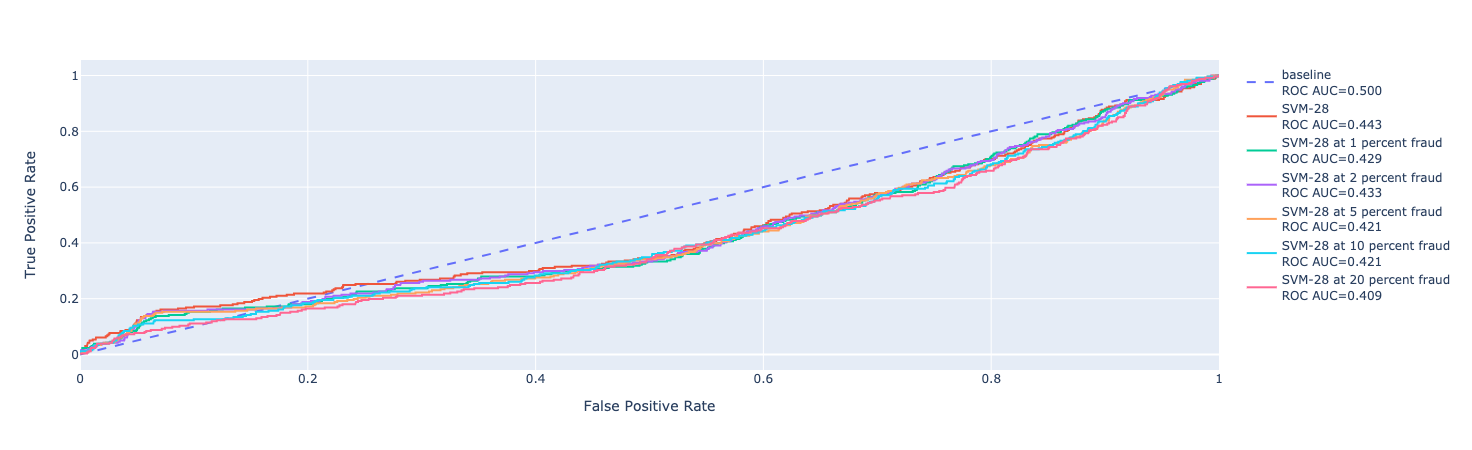

In [148]:
#SVM on 28
#At 1% fraud
#y_proba_svm_1p_raw = model1p_svm_raw.predict_proba(X_test_raw_imputed)
#y_proba_svm_1p_raw = y_proba_svm_1p_raw[:,1]
#2% fraud
#y_proba_svm_2p_raw = model2p_svm_raw.predict_proba(X_test_raw_imputed)
#y_proba_svm_2p_raw = y_proba_svm_2p_raw[:,1]
#5% fraud
#y_proba_svm_5p_raw = model5p_svm_raw.predict_proba(X_test_raw_imputed)
#y_proba_svm_5p_raw = y_proba_svm_5p_raw[:,1]
#10% fraud
#y_proba_svm_10p_raw = model10p_svm_raw.predict_proba(X_test_raw_imputed)
#y_proba_svm_10p_raw = y_proba_svm_10p_raw[:,1]
#20% fraud
#y_proba_svm_20p_raw = model20p_svm_raw.predict_proba(X_test_raw_imputed)
#y_proba_svm_20p_raw = y_proba_svm_20p_raw[:,1]

svm_raw_auc = roc_auc_score(y_test, y_proba_svm)
svm_1p_raw_auc = roc_auc_score(y_test, y_proba_svm_1p_raw)
svm_2p_raw_auc = roc_auc_score(y_test, y_proba_svm_2p_raw)
svm_5p_raw_auc = roc_auc_score(y_test, y_proba_svm_5p_raw)
svm_10p_raw_auc = roc_auc_score(y_test, y_proba_svm_10p_raw)
svm_20p_raw_auc = roc_auc_score(y_test, y_proba_svm_20p_raw)

svm_1p_raw_fpr, svm_1p_raw_tpr, _ = roc_curve(y_test, y_proba_svm_1p_raw)
svm_2p_raw_fpr, svm_2p_raw_tpr, _ = roc_curve(y_test, y_proba_svm_2p_raw)
svm_5p_raw_fpr, svm_5p_raw_tpr, _ = roc_curve(y_test, y_proba_svm_5p_raw)
svm_10p_raw_fpr, svm_10p_raw_tpr, _ = roc_curve(y_test, y_proba_svm_10p_raw)
svm_20p_raw_fpr, svm_20p_raw_tpr, _ = roc_curve(y_test, y_proba_svm_20p_raw)

fig_svm_raw = px.line()
fig_svm_raw.add_scatter(x=ns_fpr, y=ns_tpr, mode='lines', name='baseline<br>ROC AUC=%.3f' % (ns_auc), line={'dash': 'dash'}, hovertext='baseline')
fig_svm_raw.add_scatter(x=svm_fpr, y=svm_tpr, mode='lines', name='SVM-28  <br>ROC AUC=%.3f' % (svm_raw_auc), hovertext='Logit-28')
fig_svm_raw.add_scatter(x=svm_1p_raw_fpr, y=svm_1p_raw_tpr, mode='lines', name='SVM-28 at 1 percent fraud <br>ROC AUC=%.3f' % (svm_1p_raw_auc), hovertext='svm1p')
fig_svm_raw.add_scatter(x=svm_2p_raw_fpr, y=svm_2p_raw_tpr, mode='lines', name='SVM-28 at 2 percent fraud <br>ROC AUC=%.3f' % (svm_2p_raw_auc), hovertext='svm2p')
fig_svm_raw.add_scatter(x=svm_5p_raw_fpr, y=svm_5p_raw_tpr, mode='lines', name='SVM-28 at 5 percent fraud <br>ROC AUC=%.3f' % (svm_5p_raw_auc), hovertext='svm5p')
fig_svm_raw.add_scatter(x=svm_10p_raw_fpr, y=svm_10p_raw_tpr, mode='lines', name='SVM-28 at 10 percent fraud <br>ROC AUC=%.3f' % (svm_10p_raw_auc), hovertext='svm10p')
fig_svm_raw.add_scatter(x=svm_20p_raw_fpr, y=svm_20p_raw_tpr, mode='lines', name='SVM-28 at 20 percent fraud <br>ROC AUC=%.3f' % (svm_20p_raw_auc), hovertext='svm20p')
fig_svm_raw.update_xaxes(title='False Positive Rate')
fig_svm_raw.update_yaxes(title='True Positive Rate')
fig_svm_raw.show()

In [151]:
#The same for SVM-28
y_proba_svm_1p_raw_inds = y_proba_svm_1p_raw.argsort()
sorted_y_proba_svm_1p_raw = y_proba_svm_1p_raw[y_proba_svm_1p_raw_inds[::-1]]
sorted_y_test_svm_1p_raw = y_test_array[y_proba_svm_1p_raw_inds[::-1]]
sorted_y_proba_svm_1p_raw[0 : 352] = 1 
sorted_y_proba_svm_1p_raw[353:35166] = 0
sorted_y_proba_svm_1p_raw = sorted_y_proba_svm_1p_raw.astype('int64')
#At 2%
y_proba_svm_2p_raw_inds = y_proba_svm_2p_raw.argsort()
sorted_y_proba_svm_2p_raw = y_proba_svm_2p_raw[y_proba_svm_2p_raw_inds[::-1]]
sorted_y_test_svm_2p_raw = y_test_array[y_proba_svm_2p_raw_inds[::-1]]
sorted_y_proba_svm_2p_raw[0 : 352] = 1 
sorted_y_proba_svm_2p_raw[353:35166] = 0
sorted_y_proba_svm_2p_raw = sorted_y_proba_svm_2p_raw.astype('int64')
#5%
y_proba_svm_5p_raw_inds = y_proba_svm_5p_raw.argsort()
sorted_y_proba_svm_5p_raw = y_proba_svm_5p_raw[y_proba_svm_5p_raw_inds[::-1]]
sorted_y_test_svm_5p_raw = y_test_array[y_proba_svm_5p_raw_inds[::-1]]
sorted_y_proba_svm_5p_raw[0 : 352] = 1 
sorted_y_proba_svm_5p_raw[353:35166] = 0
sorted_y_proba_svm_5p_raw = sorted_y_proba_svm_5p_raw.astype('int64')
#10%
y_proba_svm_10p_raw_inds = y_proba_svm_10p_raw.argsort()
sorted_y_proba_svm_10p_raw = y_proba_svm_10p_raw[y_proba_svm_10p_raw_inds[::-1]]
sorted_y_test_svm_10p_raw = y_test_array[y_proba_svm_10p_raw_inds[::-1]]
sorted_y_proba_svm_10p_raw[0 : 352] = 1 
sorted_y_proba_svm_10p_raw[353:35166] = 0
sorted_y_proba_svm_10p_raw = sorted_y_proba_svm_10p_raw.astype('int64')
#20%
y_proba_svm_20p_raw_inds = y_proba_svm_20p_raw.argsort()
sorted_y_proba_svm_20p_raw = y_proba_svm_20p_raw[y_proba_svm_20p_raw_inds[::-1]]
sorted_y_test_svm_20p_raw = y_test_array[y_proba_svm_20p_raw_inds[::-1]]
sorted_y_proba_svm_20p_raw[0 : 352] = 1 
sorted_y_proba_svm_20p_raw[353:35166] = 0
sorted_y_proba_svm_20p_raw = sorted_y_proba_svm_20p_raw.astype('int64')

print('SVM-28 at 1% fraud, sorted\n---\n ', classification_report(sorted_y_test_svm_1p_raw, sorted_y_proba_svm_1p_raw, digits=4))
print('SVM-28 at 2% fraud, sorted\n---\n ', classification_report(sorted_y_test_svm_2p_raw, sorted_y_proba_svm_2p_raw, digits=4))
print('SVM-28 at 5% fraud, sorted\n---\n ', classification_report(sorted_y_test_svm_5p_raw, sorted_y_proba_svm_5p_raw, digits=4))
print('SVM-28 at 10% fraud, sorted\n---\n ', classification_report(sorted_y_test_svm_10p_raw, sorted_y_proba_svm_10p_raw, digits=4))
print('SVM-28 at 20% fraud, sorted\n---\n ', classification_report(sorted_y_test_svm_20p_raw, sorted_y_proba_svm_20p_raw, digits=4))

print('SVM-28 NDCG@top1%, sorted baseline: ', sklearn.metrics.ndcg_score([sorted_y_test_svm], [sorted_y_proba_svm], k=352, sample_weight=None, ignore_ties=False))
print('SVM-28 NDCG@top1%, sorted @ 1% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_svm_1p_raw], [sorted_y_proba_svm_1p_raw], k=352, sample_weight=None, ignore_ties=False))
print('SVM-28 NDCG@top1%, sorted @ 2% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_svm_2p_raw], [sorted_y_proba_svm_2p_raw], k=352, sample_weight=None, ignore_ties=False))
print('SVM-28 NDCG@top1%, sorted @ 5% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_svm_5p_raw], [sorted_y_proba_svm_5p_raw], k=352, sample_weight=None, ignore_ties=False))
print('SVM-28 NDCG@top1%, sorted @ 10% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_svm_10p_raw], [sorted_y_proba_svm_10p_raw], k=352, sample_weight=None, ignore_ties=False))
print('SVM-28 NDCG@top1%, sorted @ 20% fraud: ', sklearn.metrics.ndcg_score([sorted_y_test_svm_20p_raw], [sorted_y_proba_svm_20p_raw], k=352, sample_weight=None, ignore_ties=False))

SVM-28 at 1% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9927    0.9901    0.9914     34905
           1     0.0199    0.0268    0.0228       261

    accuracy                         0.9830     35166
   macro avg     0.5063    0.5085    0.5071     35166
weighted avg     0.9855    0.9830    0.9842     35166

SVM-28 at 2% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9927    0.9901    0.9914     34905
           1     0.0170    0.0230    0.0196       261

    accuracy                         0.9829     35166
   macro avg     0.5049    0.5065    0.5055     35166
weighted avg     0.9854    0.9829    0.9842     35166

SVM-28 at 5% fraud, sorted
---
                precision    recall  f1-score   support

           0     0.9926    0.9901    0.9914     34905
           1     0.0142    0.0192    0.0163       261

    accuracy                         0.9829     35166
   macro avg     0.5034    0.

NDCG@K Metrics printout

In [24]:
# Defining a model pipeline for easier GridSearch

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=4, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [24]:
# Alternative pipeline with option to use the faster randomsearchCV

from sklearn.model_selection import RandomizedSearchCV

def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='roc_auc',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 0):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred

In [35]:
#Utilizign randomsearch on the raw 28
from timeit import default_timer as timer

start = timer()

params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.8],
        'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 150, 200]
        }


model_raw, pred = search_pipeline(X_train_raw, X_test_raw, y_train, y_test, model_raw, 
                                 param_grid=params, cv=3, search_mode='RandomizedSearchCV', n_iterations = 10)

# ROC_AUC
print('Best ROC score: ',model_raw.best_score_)
print('Best model params: ',model_raw.best_params_)

end = timer()
time = (end-start)/60
print('Gridsearch finished in', np.round(time), 'minutes')


Fitting 3 folds for each of 10 candidates, totalling 30 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:02:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best ROC score:  0.7522721263681212
Best model params:  {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Gridsearch finished in 4.0 minutes


In [ ]:
#Utilizign randomsearch on the raw 28
from timeit import default_timer as timer

start = timer()

params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.8],
        'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 150, 200]
        }


model_raw, pred = search_pipeline(X_train_raw, X_test_raw, y_train, y_test, model_raw, 
                                 param_grid=params, cv=3, search_mode='RandomizedSearchCV', n_iterations = 10)

# ROC_AUC
print('Best ROC score: ',model_raw.best_score_)
print('Best model params: ',model_raw.best_params_)

end = timer()
time = (end-start)/60
print('Gridsearch finished in', np.round(time), 'minutes')

## 6.0 Shap Analysis

### 6.1 Shap on XGBoost

In [13]:
explainer_raw = shap.TreeExplainer(model_raw)
shap_values_raw = explainer_raw.shap_values(X_raw)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [113]:
display(np.sort(y_proba_raw)[::-1])
np.where(y_proba_raw == y_proba_raw.max())

array([8.0093807e-01, 7.8162682e-01, 7.7299076e-01, ..., 6.6221447e-04,
       5.8273086e-04, 4.3424618e-04], dtype=float32)

(array([30156]),)

In [121]:
shap.initjs()
shap.force_plot(explainer_raw.expected_value, shap_values_raw[30156,:], X_raw.iloc[30156,:], link='logit')
#plt.savefig('shap_pred', bbox_inches='tight')

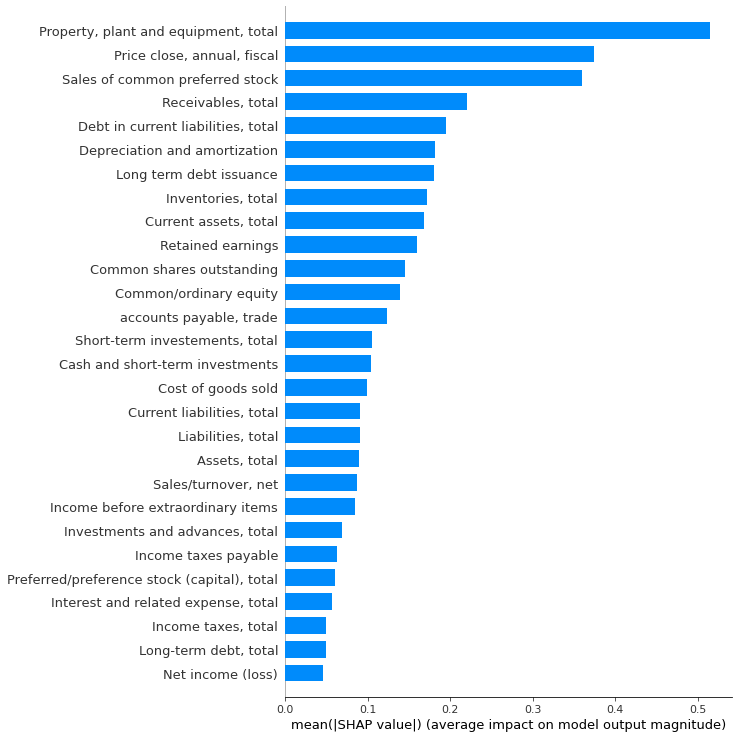

In [14]:
#Shap summary plot for the XGB-28 model, showing the average influence on the output
shap.summary_plot(shap_values_raw, X_raw, plot_type='bar', show=False, max_display=30)
#plt.savefig('shap_summary_raw', bbox_inches='tight')

In [26]:
mean_shap_feature_values = pd.DataFrame(shap_values_raw, columns=X_raw.columns).abs().mean(axis=0).sort_values(ascending=False)
display(mean_shap_feature_values)

Property, plant and equipment, total           0.515234
Price close, annual, fiscal                    0.373733
Sales of common preferred stock                0.359938
Receivables, total                             0.220593
Debt in current liabilities, total             0.194789
Depreciation and amortization                  0.181520
Long term debt issuance                        0.180733
Inventories, total                             0.171483
Current assets, total                          0.168390
Retained earnings                              0.160253
Common shares outstanding                      0.145000
Common/ordinary equity                         0.138676
accounts payable, trade                        0.123579
Short-term investements, total                 0.105493
Cash and short-term investments                0.103666
Cost of goods sold                             0.098907
Current liabilities, total                     0.090234
Liabilities, total                             0

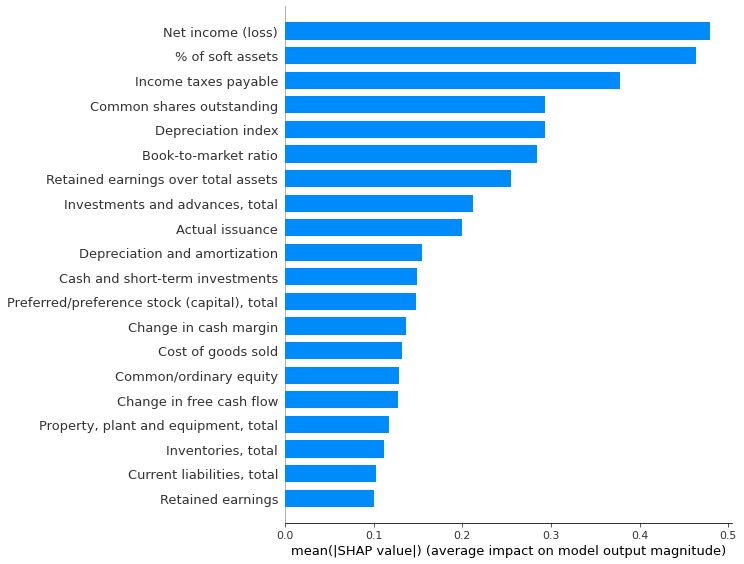

In [274]:
#SHAP Summary on the XGB-42 model
shap.summary_plot(shap_values, X, plot_type='bar', show=False)
plt.savefig('shap_summary_42', bbox_inches='tight')

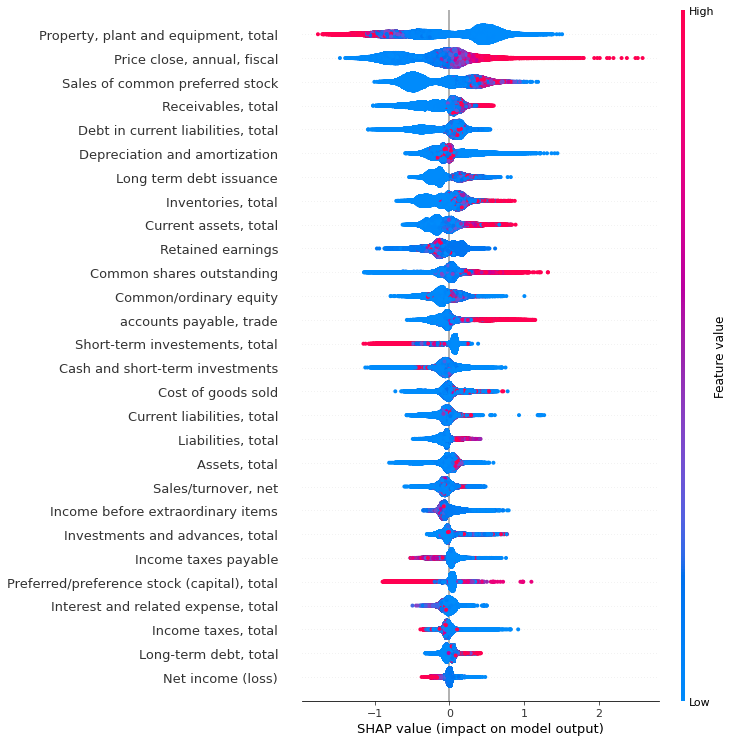

In [38]:
#Shap summary plot with the how the values of each feature interacts on XGB-28
shap.summary_plot(shap_values_raw, X_raw, show=False, max_display=30)
plt.savefig('shap_summary_28_interact', bbox_inches='tight')

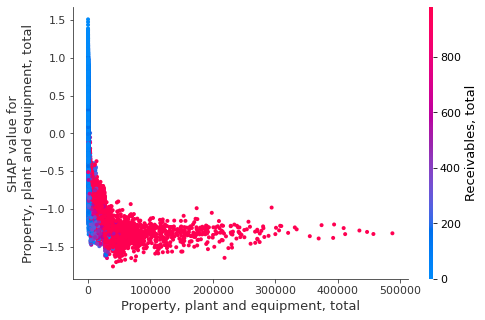

In [39]:
shap.dependence_plot(5, shap_values_raw, X_raw)

### 6.2 SHAP on augmented XGboost

In [47]:
explainer_raw_5p = shap.TreeExplainer(model5p_raw)
shap_values_raw_5p = explainer_raw_5p.shap_values(X_raw)

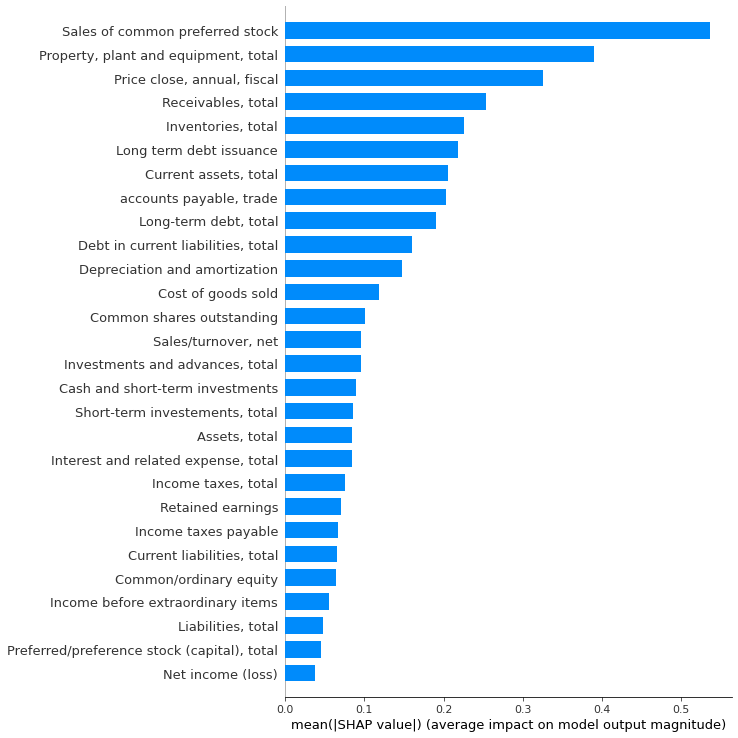

In [50]:
#Shap summary plot for the XGB-28 model, showing the average influence on the output
shap.summary_plot(shap_values_raw_5p, X_raw, plot_type='bar', show=False, max_display=30)

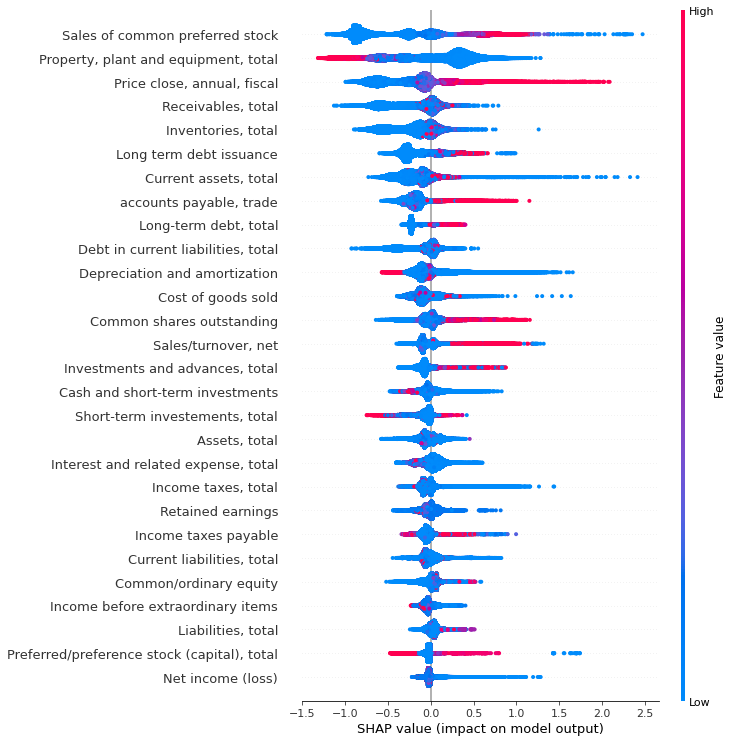

In [56]:
shap.summary_plot(shap_values_raw_5p, X_raw, show=False, max_display=30)
plt.savefig('shap_summary_28_interact_5p', bbox_inches='tight')

In [52]:
mean_shap_feature_values_5p = pd.DataFrame(shap_values_raw_5p, columns=X_raw.columns).abs().mean(axis=0).sort_values(ascending=False)
display(mean_shap_feature_values_5p)

Sales of common preferred stock                0.536963
Property, plant and equipment, total           0.390215
Price close, annual, fiscal                    0.325839
Receivables, total                             0.253810
Inventories, total                             0.225865
Long term debt issuance                        0.217839
Current assets, total                          0.205819
accounts payable, trade                        0.203527
Long-term debt, total                          0.190853
Debt in current liabilities, total             0.160387
Depreciation and amortization                  0.148116
Cost of goods sold                             0.117866
Common shares outstanding                      0.100859
Sales/turnover, net                            0.095220
Investments and advances, total                0.095196
Cash and short-term investments                0.088839
Short-term investements, total                 0.085497
Assets, total                                  0

## Appendix 
Short test using oversampling with SMOTE

In [71]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

smote_on_1 = 12835
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=42, sampling_strategy={1: smote_on_1})
X_train_raw_sm, y_train_raw_sm = sm.fit_resample(X_train_raw, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_raw_sm)))

Original dataset shape Counter({0: 66667, 1: 499})
Resampled dataset shape Counter({0: 66667, 1: 12835})


In [72]:
model_raw_sm = XGBClassifier(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=150, subsample=0.8, scale_pos_weight = math.sqrt(146045/975))
model_raw_sm.fit(X_train_raw_sm, y_train_raw_sm)

[11:07:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.238862021844334,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [75]:
y_proba_raw_sm = model_raw_sm.predict_proba(X_test_raw)
y_proba_raw_sm = y_proba_raw_sm[:,1]
# calculate scores
xgb_raw_sm_auc = roc_auc_score(y_test, y_proba_raw_sm)
# summarize scores
print('XGB-28 with 20percent SMOTE: ROC AUC=%.3f' % (xgb_raw_sm_auc))

XGB-28 with 20p SMOTE: ROC AUC=0.714
